# РАЗДЕЛ 3. Конструирование признаков

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, ARDRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline 
sns.set(style="ticks")

## Попробуем изменить качество и количество признаков и оценить их влияние на точность модели 
    3.1. Удалим из dataset выбросы
    3.2. Переведем в категориальный признак "Угол нашивки, град"
    3.3. Сократим количество признаков, оказывающих наименьшее влияние на модель.

Для сравнительного анализа возьмем теже алгоритмы машинного обучения, что и в разделе 2:
В качестве метрики для оценки моделей возьмём среднюю абсолютную ошибку (mae) 

In [2]:
# объект для хранения оценок различных моделей
# под y1 - закодирован целевой признак "Модуль упругости при растяжении, ГПа"
# под y2 - закодирован целевой признак "Прочность при растяжении, МПа"

modelsMAE_y1=[]
modelsMAE_y2=[]

In [3]:
# Подготовка данных для обучения
path_1 = r'./Data/X.xlsx'
X = pd.read_excel(path_1,index_col=0)
X.head()


,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,220.0,0,4.0,57.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,220.0,0,4.0,60.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,220.0,0,4.0,70.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,220.0,0,5.0,47.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,220.0,0,5.0,57.0


In [4]:
path_2 = r'./Data/y.xlsx'
y = pd.read_excel(path_2,index_col=0)
y1 = y.drop(columns='Прочность при растяжении, МПа')
y2 = y.drop(columns='Модуль упругости при растяжении, ГПа')
y2.head()

,"Прочность при растяжении, МПа"
0,3000.0
1,3000.0
2,3000.0
3,3000.0
4,3000.0


### 3.1 Влияние аномалий на качество моделей

In [5]:
# удаление аномалий из исходного dataset

X_clear = X.copy()
X_clear = X_clear.join(y,how='inner')
print(X_clear.shape)
for name in X_clear.columns:
    outlier = boxplot_stats(X_clear[name])
    High = outlier[0]['whishi']
    Low =  outlier[0]['whislo']
    print ('Количество выбросов в столбце ', name, ': ', len(outlier[0]['fliers']))
    X_clear = X_clear[~((X_clear[name] < Low) | (X_clear[name] > High))]
print(X_clear.shape)  
y_clear = X_clear[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
X_clear = X_clear.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'], axis=1)

(1023, 13)
Количество выбросов в столбце  Соотношение матрица-наполнитель :  6
Количество выбросов в столбце  Плотность, кг/м3 :  9
Количество выбросов в столбце  модуль упругости, ГПа :  2
Количество выбросов в столбце  Количество отвердителя, м.% :  14
Количество выбросов в столбце  Содержание эпоксидных групп,%_2 :  2
Количество выбросов в столбце  Температура вспышки, С_2 :  6
Количество выбросов в столбце  Поверхностная плотность, г/м2 :  2
Количество выбросов в столбце  Потребление смолы, г/м2 :  5
Количество выбросов в столбце  Угол нашивки, град :  0
Количество выбросов в столбце  Шаг нашивки :  4
Количество выбросов в столбце  Плотность нашивки :  21
Количество выбросов в столбце  Модуль упругости при растяжении, ГПа :  6
Количество выбросов в столбце  Прочность при растяжении, МПа :  13
(933, 13)


In [6]:
# стандартизация очищенных данных
scaler_std = StandardScaler()
scaler_std.fit(X_clear)
Xstd = pd.DataFrame (data =scaler_std.transform(X_clear), columns=X_clear.columns)
scaler_std_y = StandardScaler()
scaler_std_y.fit(y_clear)
ystd = pd.DataFrame (data = scaler_std_y.transform(y_clear), columns=y_clear.columns)

In [7]:
# нормализация очищенных данных
scaler_norm = MinMaxScaler()
scaler_norm.fit(X_clear)
Xnorm = pd.DataFrame (data =scaler_norm.transform(X_clear), columns=X_clear.columns)
scaler_norm_y = MinMaxScaler()
scaler_norm_y.fit(y_clear)
ynorm = pd.DataFrame (data = scaler_norm_y.transform(y_clear), columns=y_clear.columns)

In [8]:
#разбиение очищенных данных на тестовую и тренировочную часть
X_train, X_test, y_train, y_test = train_test_split(X_clear, y_clear, test_size=0.2, random_state=42, shuffle=True)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(Xnorm,ynorm, test_size=0.2, random_state=42, shuffle=True)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(Xstd,ystd, test_size=0.2, random_state=42, shuffle=True)

In [9]:
# модель линейной регрессии тренируем на исходных данных
modelLinReg = LinearRegression()
modelLinReg.fit(X_train,y_train)
y_pred = modelLinReg.predict(X_test)
MAELinReg_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAELinReg_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAELinReg_1)
print (MAELinReg_2)

2.540146624552066
373.7949432252731


In [10]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['LinearRegression',MAELinReg_1])
modelsMAE_y2.append(['LinearRegression',MAELinReg_2])

In [11]:
# модель линейной регрессии Ridge тренируем на исходных данных
modelRidge = Ridge(alpha=1500.0)
modelRidge.fit(X_train,y_train)
y_pred = modelRidge.predict(X_test)
MAERidge_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAERidge_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAERidge_1)
print (MAERidge_2)

2.537882445323928
372.5756003651178


In [12]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['Ridge',MAERidge_1])
modelsMAE_y2.append(['Ridge',MAERidge_2])

In [13]:
# модель линейной регрессии Ridge тренируем на нормализованных данных
modelRidge = Ridge(alpha=16.0)
modelRidge.fit(X_train_norm,y_train_norm)
print (modelRidge.predict(X_test_norm).shape)
y_pred =  scaler_norm_y.inverse_transform (modelRidge.predict(X_test_norm))
MAERidge_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAERidge_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAERidge_1)
print (MAERidge_2)

(187, 2)
2.5282308269375346
370.91379516311537


In [14]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['Ridge_norm',MAERidge_1])
modelsMAE_y2.append(['Ridge_norm',MAERidge_2])

In [15]:
# модель линейной регрессии Ridge тренируем на стандартизованных данных данных
modelRidge = Ridge(alpha=1000)
modelRidge.fit(X_train_std,y_train_std)
y_pred =  scaler_std_y.inverse_transform (modelRidge.predict(X_test_std))
MAERidge_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAERidge_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAERidge_1)
print (MAERidge_2)

2.5243440708702085
370.3589675933003


In [16]:
modelsMAE_y1.append(['Ridge_std',MAERidge_1])
modelsMAE_y2.append(['Ridge_std',MAERidge_2])


In [17]:
# модель линейной регрессии Lasso тренируем на исходных данных
modelLasso = Lasso(alpha=0.1)
modelLasso.fit(X_train,y_train)
y_pred = modelLasso.predict(X_test)
MAELasso_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAELasso_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])

print (MAELasso_1)
print (MAELasso_2)

2.5366102088742966
373.7803735026631


In [18]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['Lasso',MAELasso_1])
modelsMAE_y2.append(['Lasso',MAELasso_2])

In [19]:
# модель линейной регрессии ElasticNet тренируем на исходных данных
modelElastic = ElasticNet(alpha=0.1, l1_ratio=0.9)
modelElastic.fit(X_train,y_train)
y_pred = modelElastic.predict(X_test)
MAEElastic_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAEElastic_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])

print (MAEElastic_1)
print (MAEElastic_2)

2.5371148330146633
373.7644266803178


In [20]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['ElasticNet',MAEElastic_1])
modelsMAE_y2.append(['ElasticNet',MAEElastic_2])

In [21]:
# модель регрессии BayesianRidge тренируем на исходных данных
modelBay_1=BayesianRidge()
modelBay_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelBay_1.predict(X_test)
MAEBay_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelBay_2 = BayesianRidge()
modelBay_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelBay_2.predict(X_test)
MAEBay_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)

print (MAEBay_1)
print (MAEBay_2)

2.5256467365389312
370.75537355915486


In [22]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['BayesianRidge',MAEBay_1])
modelsMAE_y2.append(['BayesianRidge',MAEBay_2])

In [23]:
# модель регрессии GradientBoostingRegressor тренируем на исходных данных
modelGBR_1 = GradientBoostingRegressor()
modelGBR_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelGBR_1.predict(X_test)
MAEGBR_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelGBR_2 = GradientBoostingRegressor()
modelGBR_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelGBR_2.predict(X_test)
MAEGBR_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)

print (MAEGBR_1)
print (MAEGBR_2)

2.540920559419069
377.2802156316299


In [24]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['GradientBoostingRegressor',MAEGBR_1])
modelsMAE_y2.append(['GradientBoostingRegressor',MAEGBR_2])

In [25]:
# модель регрессии GradientBoostingRegressor тренируем на нормализованных данных
modelGBR_1 = GradientBoostingRegressor()
modelGBR_1.fit(X_train_norm,y_train_norm.iloc[:,0])
y_pred1 = modelGBR_1.predict(X_test_norm)
modelGBR_2 = GradientBoostingRegressor()
modelGBR_2.fit(X_train_norm,y_train_norm.iloc[:,1])
y_pred2 = modelGBR_2.predict(X_test_norm)
y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_norm_y.inverse_transform (y_pred)

MAEGBR_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAEGBR_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAEGBR_1)
print (MAEGBR_2)

2.5463129464347873
377.26742329868335


In [26]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['GradientBoostingRegressor_norm',MAEGBR_1])
modelsMAE_y2.append(['GradientBoostingRegressor_norm',MAEGBR_2])

In [27]:
# модель регрессии GradientBoostingRegressor тренируем на стандартизованных данных
modelGBR_1 = GradientBoostingRegressor()
modelGBR_1.fit(X_train_std,y_train_std.iloc[:,0])
y_pred1 = modelGBR_1.predict(X_test_std)
modelGBR_2 = GradientBoostingRegressor()
modelGBR_2.fit(X_train_std,y_train_std.iloc[:,1])
y_pred2 = modelGBR_2.predict(X_test_std)
y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_std_y.inverse_transform (y_pred)

MAEGBR_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAEGBR_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAEGBR_1)
print (MAEGBR_2)

2.5457577907816944
378.77860924776246


In [28]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['GradientBoostingRegressor_std',MAEGBR_1])
modelsMAE_y2.append(['GradientBoostingRegressor_std',MAEGBR_2])

In [29]:
modelsMAE_y1

[['LinearRegression', 2.540146624552066],
 ['Ridge', 2.537882445323928],
 ['Ridge_norm', 2.5282308269375346],
 ['Ridge_std', 2.5243440708702085],
 ['Lasso', 2.5366102088742966],
 ['ElasticNet', 2.5371148330146633],
 ['BayesianRidge', 2.5256467365389312],
 ['GradientBoostingRegressor', 2.540920559419069],
 ['GradientBoostingRegressor_norm', 2.5463129464347873],
 ['GradientBoostingRegressor_std', 2.5457577907816944]]

In [30]:
# модель регрессии KNeighborsRegressor тренируем на исходных данных
modelNeihg_1 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelNeihg_1.predict(X_test)
MAENeihg_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelNeihg_2 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelNeihg_2.predict(X_test)
MAENeihg_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)
print (MAENeihg_1)
print (MAENeihg_2)

2.609709581254126
392.1509689004053


In [31]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['KNeighborsRegressor',MAENeihg_1])
modelsMAE_y2.append(['KNeighborsRegressor',MAENeihg_2])

In [32]:
# модель регрессии KNeighborsRegressor тренируем на нормализованных данных
modelNeihg_1 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_1.fit(X_train_norm, y_train_norm.iloc[:,0])
y_pred1 = modelNeihg_1.predict(X_test_norm)
modelNeihg_2 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_2.fit(X_train_norm,y_train_norm.iloc[:,1])
y_pred2 = modelNeihg_2.predict(X_test_norm)
y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_norm_y.inverse_transform (y_pred)

MAENeihg_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAENeihg_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAENeihg_1)
print (MAENeihg_2)

2.5475175535665717
385.7733933281766


In [33]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['KNeighborsRegressor_norm',MAENeihg_1])
modelsMAE_y2.append(['KNeighborsRegressor_norm',MAENeihg_2])

In [34]:
# модель регрессии KNeighborsRegressor тренируем на стандартизованных данных
modelNeihg_1 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_1.fit(X_train_std,y_train_std.iloc[:,0])
y_pred1 = modelNeihg_1.predict(X_test_std)
modelNeihg_2 = KNeighborsRegressor(n_neighbors=13)
modelNeihg_2.fit(X_train_norm,y_train_std.iloc[:,1])
y_pred2 = modelNeihg_2.predict(X_test_std)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_std_y.inverse_transform (y_pred)

MAENeihg_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAENeihg_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAENeihg_1)
print (MAENeihg_2)

2.5434973895923045
400.8241620766011


In [35]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['KNeighborsRegressor_std',MAENeihg_1])
modelsMAE_y2.append(['KNeighborsRegressor_std',MAENeihg_2])

In [36]:
# модель регрессии DecisionTreeRegressor тренируем на исходных данных
modelTree_1 = DecisionTreeRegressor(max_depth=5)
modelTree_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelTree_1.predict(X_test)
MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelTree_2 = DecisionTreeRegressor(max_depth=5)
modelTree_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelTree_2.predict(X_test)
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)
print (MAETree_1)
print (MAETree_2)

2.714313595456014
401.35825569836464


In [37]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['DecisionTreeRegressor',MAETree_1])
modelsMAE_y2.append(['DecisionTreeRegressor',MAETree_2])

In [38]:
# модель регрессии DecisionTreeRegressor тренируем на нормализованных данных
modelTree_1 = DecisionTreeRegressor(max_depth=5)
modelTree_1.fit(X_train_norm,y_train_norm.iloc[:,0])
y_pred1 = modelTree_1.predict(X_test_norm)

modelTree_2 = DecisionTreeRegressor(max_depth=5)
modelTree_2.fit(X_train_norm,y_train_norm.iloc[:,1])
y_pred2 = modelTree_2.predict(X_test_norm)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_norm_y.inverse_transform (y_pred)

MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAETree_1)
print (MAETree_2)

2.71431359545601
394.68514033989635


In [39]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['DecisionTreeRegressor_norm',MAETree_1])
modelsMAE_y2.append(['DecisionTreeRegressor_norm',MAETree_2])

In [40]:
# модель регрессии DecisionTreeRegressor тренируем на стандартизованных данных
modelTree_1 = DecisionTreeRegressor(max_depth=5)
modelTree_1.fit(X_train_std,y_train_std.iloc[:,0])
y_pred1 = modelTree_1.predict(X_test_std)

modelTree_2 = DecisionTreeRegressor(max_depth=5)
modelTree_2.fit(X_train_std,y_train_std.iloc[:,1])
y_pred2 = modelTree_2.predict(X_test_std)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_std_y.inverse_transform (y_pred)

MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAETree_1)
print (MAETree_2)

2.714313595456011
401.35825569836476


In [41]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['DecisionTreeRegressor_std',MAETree_1])
modelsMAE_y2.append(['DecisionTreeRegressor_std',MAETree_2])

In [42]:
# модель регрессии RandomForestRegressor тренируем на исходных данных
modelTree_1 = RandomForestRegressor(max_depth=5)
modelTree_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelTree_1.predict(X_test)
MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelTree_2 = RandomForestRegressor(max_depth=5)
modelTree_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelTree_2.predict(X_test)
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)
print (MAETree_1)
print (MAETree_2)

2.498641311209863
375.99597021415144


In [43]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['RandomForestRegressor',MAETree_1])
modelsMAE_y2.append(['RandomForestRegressor',MAETree_2])

In [44]:
# модель регрессии RandomForestRegressor тренируем на нормализованных данных
modelTree_1 = RandomForestRegressor(max_depth=5)
modelTree_1.fit(X_train_norm,y_train_norm.iloc[:,0])
y_pred1 = modelTree_1.predict(X_test_norm)

modelTree_2 = RandomForestRegressor(max_depth=5)
modelTree_2.fit(X_train_norm,y_train_norm.iloc[:,1])
y_pred2 = modelTree_2.predict(X_test_norm)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_norm_y.inverse_transform (y_pred)

MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAETree_1)
print (MAETree_2)

2.5295678037605027
374.8413455204395


In [45]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['RandomForestRegressor_norm',MAETree_1])
modelsMAE_y2.append(['RandomForestRegressor_norm',MAETree_2])

In [46]:
# модель регрессии RandomForestRegressor тренируем на стандартизованных данных
modelTree_1 = RandomForestRegressor(max_depth=5)
modelTree_1.fit(X_train_std,y_train_std.iloc[:,0])
y_pred1 = modelTree_1.predict(X_test_std)

modelTree_2 = RandomForestRegressor(max_depth=5)
modelTree_2.fit(X_train_std,y_train_std.iloc[:,1])
y_pred2 = modelTree_2.predict(X_test_std)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_std_y.inverse_transform (y_pred)

MAETree_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAETree_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAETree_1)
print (MAETree_2)

2.5278521538194814
376.7599376943874


In [47]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['RandomForestRegressor_std',MAETree_1])
modelsMAE_y2.append(['RandomForestRegressor_std',MAETree_2])

In [48]:
# модель регрессии AdaBoostRegressor тренируем на исходных данных
modelAda_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_1.fit(X_train,y_train.iloc[:,0])
y_pred_1 = modelAda_1.predict(X_test)
MAEAda_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
modelAda_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_2.fit(X_train,y_train.iloc[:,1])
y_pred_2 = modelAda_2.predict(X_test)
MAEAda_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)
print (MAEAda_1)
print (MAEAda_2)

2.561115880963196
376.87481049283906


In [49]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['AdaBoostRegressor',MAEAda_1])
modelsMAE_y2.append(['AdaBoostRegressor',MAEAda_2])

In [50]:
# модель регрессии AdaBoostRegressor тренируем на нормализованных данных
modelAda_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_1.fit(X_train_norm,y_train_norm.iloc[:,0])
y_pred1 = modelAda_1.predict(X_test_norm)

modelAda_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_2.fit(X_train_norm,y_train_norm.iloc[:,1])
y_pred2 = modelAda_2.predict(X_test_norm)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_norm_y.inverse_transform (y_pred)

MAEAda_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAEAda_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAEAda_1)
print (MAEAda_2)

2.537263250103053
385.15444070270576


In [51]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['AdaBoostRegressor_norm',MAEAda_1])
modelsMAE_y2.append(['AdaBoostRegressor_norm',MAEAda_2])

In [52]:
# модель регрессии AdaBoostRegressor тренируем на стандартизованных данных
modelAda_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_1.fit(X_train_std,y_train_std.iloc[:,0])
y_pred1 = modelAda_1.predict(X_test_std)

modelAda_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
modelAda_2.fit(X_train_std,y_train_std.iloc[:,1])
y_pred2 = modelAda_2.predict(X_test_std)

y_pred = np.vstack((y_pred1,y_pred2)).T
y_pred = scaler_std_y.inverse_transform (y_pred)

MAEAda_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
MAEAda_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAEAda_1)
print (MAEAda_2)

2.607058108789952
386.85003862848384


In [53]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['AdaBoostRegressor_std',MAEAda_1])
modelsMAE_y2.append(['AdaBoostRegressor_std',MAEAda_2])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
21/21 - 1s - loss: 5532.9741 - mae: 74.3234 - val_loss: 5528.0386 - val_mae: 74.2779 - 789ms/epoch - 38ms/step
Epoch 2/200
21/21 - 0s - loss: 5435.0273 - mae: 73.6622 - val_loss: 5432.7695 - val_mae: 73.6337 - 38ms/epoch - 2ms/step
Epoch 3/200
21/21 - 0s - loss: 5342.4521 - mae: 73.0308 - val_loss: 5341.9341 

Epoch 62/200
21/21 - 0s - loss: 1529.5298 - mae: 38.9944 - val_loss: 1530.6974 - val_mae: 38.9853 - 37ms/epoch - 2ms/step
Epoch 63/200
21/21 - 0s - loss: 1482.6141 - mae: 38.3872 - val_loss: 1482.9337 - val_mae: 38.3678 - 37ms/epoch - 2ms/step
Epoch 64/200
21/21 - 0s - loss: 1434.2384 - mae: 37.7517 - val_loss: 1432.6560 - val_mae: 37.7069 - 37ms/epoch - 2ms/step
Epoch 65/200
21/21 - 0s - loss: 1382.5956 - mae: 37.0615 - val_loss: 1378.6663 - val_mae: 36.9841 - 40ms/epoch - 2ms/step
Epoch 66/200
21/21 - 0s - loss: 1328.0382 - mae: 36.3192 - val_loss: 1323.1907 - val_mae: 36.2263 - 39ms/epoch - 2ms/step
Epoch 67/200
21/21 - 0s - loss: 1273.2463 - mae: 35.5558 - val_loss: 1268.3250 - val_mae: 35.4610 - 36ms/epoch - 2ms/step
Epoch 68/200
21/21 - 0s - loss: 1219.7699 - mae: 34.7981 - val_loss: 1215.8639 - val_mae: 34.7134 - 37ms/epoch - 2ms/step
Epoch 69/200
21/21 - 0s - loss: 1169.2471 - mae: 34.0617 - val_loss: 1166.3738 - val_mae: 33.9931 - 37ms/epoch - 2ms/step
Epoch 70/200
21/21 - 0s 

Epoch 130/200
21/21 - 0s - loss: 100.2452 - mae: 9.5547 - val_loss: 105.5746 - val_mae: 9.7329 - 37ms/epoch - 2ms/step
Epoch 131/200
21/21 - 0s - loss: 95.6277 - mae: 9.3101 - val_loss: 100.8964 - val_mae: 9.4895 - 37ms/epoch - 2ms/step
Epoch 132/200
21/21 - 0s - loss: 91.1975 - mae: 9.0681 - val_loss: 96.4049 - val_mae: 9.2498 - 38ms/epoch - 2ms/step
Epoch 133/200
21/21 - 0s - loss: 86.9462 - mae: 8.8306 - val_loss: 92.1088 - val_mae: 9.0146 - 36ms/epoch - 2ms/step
Epoch 134/200
21/21 - 0s - loss: 82.8750 - mae: 8.5974 - val_loss: 87.9988 - val_mae: 8.7837 - 38ms/epoch - 2ms/step
Epoch 135/200
21/21 - 0s - loss: 78.9832 - mae: 8.3682 - val_loss: 84.0553 - val_mae: 8.5563 - 37ms/epoch - 2ms/step
Epoch 136/200
21/21 - 0s - loss: 75.2553 - mae: 8.1429 - val_loss: 80.2798 - val_mae: 8.3327 - 38ms/epoch - 2ms/step
Epoch 137/200
21/21 - 0s - loss: 71.6930 - mae: 7.9210 - val_loss: 76.6604 - val_mae: 8.1127 - 38ms/epoch - 2ms/step
Epoch 138/200
21/21 - 0s - loss: 68.2766 - mae: 7.7033 - val_

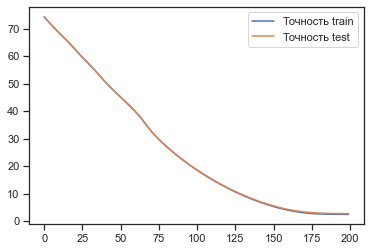

In [54]:
# модель полносвязной нейронной сети для целевого параметра y1 тренируем на исходных данных
modelNN_y1 = Sequential()
modelNN_y1.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y1.add(Dense(32, activation = 'sigmoid'))
modelNN_y1.add(Dense(1, activation = 'linear'))
modelNN_y1.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y1.summary()
history = modelNN_y1.fit(X_train,y_train.iloc[:,0], 
                    epochs=200, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

In [55]:
y_pred_1 = modelNN_y1.predict(X_test)
MAENN_1 = mean_absolute_error(y_test.iloc[:,0],y_pred_1)
print (MAENN_1)

6/6 [==============================] - 0s 798us/step
2.5190521656990286


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                192       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
21/21 - 1s - loss: 6341066.5000 - mae: 2475.4219 - val_loss: 6025778.5000 - val_mae: 2416.5752 - 642ms/epoch - 31ms/step
Epoch 2/4000
21/21 - 0s - loss: 6338316.5000 - mae: 2474.8679 - val_loss: 6023053.0000 - val_mae: 2416.0117 - 52ms/epoch - 2ms/step
Epoch 3/4000
21/21 - 0s - loss: 6335484.5000 - mae: 24

Epoch 57/4000
21/21 - 0s - loss: 6151027.0000 - mae: 2436.7366 - val_loss: 5839757.0000 - val_mae: 2377.7737 - 38ms/epoch - 2ms/step
Epoch 58/4000
21/21 - 0s - loss: 6147325.5000 - mae: 2435.9771 - val_loss: 5836164.5000 - val_mae: 2377.0183 - 37ms/epoch - 2ms/step
Epoch 59/4000
21/21 - 0s - loss: 6143675.5000 - mae: 2435.2258 - val_loss: 5832622.5000 - val_mae: 2376.2734 - 38ms/epoch - 2ms/step
Epoch 60/4000
21/21 - 0s - loss: 6140073.5000 - mae: 2434.4863 - val_loss: 5829133.5000 - val_mae: 2375.5391 - 37ms/epoch - 2ms/step
Epoch 61/4000
21/21 - 0s - loss: 6136519.5000 - mae: 2433.7554 - val_loss: 5825681.5000 - val_mae: 2374.8123 - 37ms/epoch - 2ms/step
Epoch 62/4000
21/21 - 0s - loss: 6133002.0000 - mae: 2433.0325 - val_loss: 5822270.5000 - val_mae: 2374.0938 - 37ms/epoch - 2ms/step
Epoch 63/4000
21/21 - 0s - loss: 6129524.5000 - mae: 2432.3162 - val_loss: 5818884.5000 - val_mae: 2373.3804 - 38ms/epoch - 2ms/step
Epoch 64/4000
21/21 - 0s - loss: 6126071.0000 - mae: 2431.6069 - val_

Epoch 119/4000
21/21 - 0s - loss: 5919365.5000 - mae: 2388.7261 - val_loss: 5613802.0000 - val_mae: 2329.7751 - 38ms/epoch - 2ms/step
Epoch 120/4000
21/21 - 0s - loss: 5915823.5000 - mae: 2387.9868 - val_loss: 5610366.5000 - val_mae: 2329.0378 - 38ms/epoch - 2ms/step
Epoch 121/4000
21/21 - 0s - loss: 5912303.5000 - mae: 2387.2485 - val_loss: 5606928.0000 - val_mae: 2328.2996 - 38ms/epoch - 2ms/step
Epoch 122/4000
21/21 - 0s - loss: 5908787.0000 - mae: 2386.5115 - val_loss: 5603505.0000 - val_mae: 2327.5645 - 37ms/epoch - 2ms/step
Epoch 123/4000
21/21 - 0s - loss: 5905282.5000 - mae: 2385.7771 - val_loss: 5600089.0000 - val_mae: 2326.8303 - 38ms/epoch - 2ms/step
Epoch 124/4000
21/21 - 0s - loss: 5901788.0000 - mae: 2385.0432 - val_loss: 5596678.5000 - val_mae: 2326.0974 - 38ms/epoch - 2ms/step
Epoch 125/4000
21/21 - 0s - loss: 5898292.0000 - mae: 2384.3123 - val_loss: 5593291.5000 - val_mae: 2325.3696 - 39ms/epoch - 2ms/step
Epoch 126/4000
21/21 - 0s - loss: 5894817.0000 - mae: 2383.584

Epoch 181/4000
21/21 - 0s - loss: 5710912.5000 - mae: 2344.6868 - val_loss: 5410654.5000 - val_mae: 2285.7617 - 38ms/epoch - 2ms/step
Epoch 182/4000
21/21 - 0s - loss: 5707651.0000 - mae: 2343.9944 - val_loss: 5407494.5000 - val_mae: 2285.0703 - 37ms/epoch - 2ms/step
Epoch 183/4000
21/21 - 0s - loss: 5704412.0000 - mae: 2343.2991 - val_loss: 5404307.0000 - val_mae: 2284.3726 - 37ms/epoch - 2ms/step
Epoch 184/4000
21/21 - 0s - loss: 5701153.0000 - mae: 2342.6033 - val_loss: 5401136.0000 - val_mae: 2283.6782 - 38ms/epoch - 2ms/step
Epoch 185/4000
21/21 - 0s - loss: 5697901.0000 - mae: 2341.9092 - val_loss: 5397970.0000 - val_mae: 2282.9851 - 37ms/epoch - 2ms/step
Epoch 186/4000
21/21 - 0s - loss: 5694649.0000 - mae: 2341.2178 - val_loss: 5394813.0000 - val_mae: 2282.2935 - 38ms/epoch - 2ms/step
Epoch 187/4000
21/21 - 0s - loss: 5691407.5000 - mae: 2340.5254 - val_loss: 5391649.5000 - val_mae: 2281.6003 - 43ms/epoch - 2ms/step
Epoch 188/4000
21/21 - 0s - loss: 5688167.0000 - mae: 2339.830

Epoch 243/4000
21/21 - 0s - loss: 5512283.0000 - mae: 2301.9407 - val_loss: 5217091.0000 - val_mae: 2243.0205 - 37ms/epoch - 2ms/step
Epoch 244/4000
21/21 - 0s - loss: 5509125.5000 - mae: 2301.2554 - val_loss: 5214016.0000 - val_mae: 2242.3350 - 37ms/epoch - 2ms/step
Epoch 245/4000
21/21 - 0s - loss: 5505969.0000 - mae: 2300.5696 - val_loss: 5210940.5000 - val_mae: 2241.6494 - 38ms/epoch - 2ms/step
Epoch 246/4000
21/21 - 0s - loss: 5502814.0000 - mae: 2299.8843 - val_loss: 5207865.5000 - val_mae: 2240.9634 - 38ms/epoch - 2ms/step
Epoch 247/4000
21/21 - 0s - loss: 5499658.5000 - mae: 2299.1980 - val_loss: 5204793.0000 - val_mae: 2240.2776 - 38ms/epoch - 2ms/step
Epoch 248/4000
21/21 - 0s - loss: 5496509.0000 - mae: 2298.5115 - val_loss: 5201715.5000 - val_mae: 2239.5906 - 37ms/epoch - 2ms/step
Epoch 249/4000
21/21 - 0s - loss: 5493357.0000 - mae: 2297.8245 - val_loss: 5198640.0000 - val_mae: 2238.9041 - 38ms/epoch - 2ms/step
Epoch 250/4000
21/21 - 0s - loss: 5490202.5000 - mae: 2297.138

Epoch 305/4000
21/21 - 0s - loss: 5318650.5000 - mae: 2259.4900 - val_loss: 5028460.5000 - val_mae: 2200.5706 - 37ms/epoch - 2ms/step
Epoch 306/4000
21/21 - 0s - loss: 5315557.5000 - mae: 2258.8069 - val_loss: 5025456.0000 - val_mae: 2199.8882 - 37ms/epoch - 2ms/step
Epoch 307/4000
21/21 - 0s - loss: 5312470.0000 - mae: 2258.1230 - val_loss: 5022453.0000 - val_mae: 2199.2053 - 37ms/epoch - 2ms/step
Epoch 308/4000
21/21 - 0s - loss: 5309386.5000 - mae: 2257.4402 - val_loss: 5019442.0000 - val_mae: 2198.5205 - 36ms/epoch - 2ms/step
Epoch 309/4000
21/21 - 0s - loss: 5306304.5000 - mae: 2256.7544 - val_loss: 5016425.0000 - val_mae: 2197.8345 - 38ms/epoch - 2ms/step
Epoch 310/4000
21/21 - 0s - loss: 5303213.0000 - mae: 2256.0708 - val_loss: 5013423.0000 - val_mae: 2197.1514 - 37ms/epoch - 2ms/step
Epoch 311/4000
21/21 - 0s - loss: 5300127.5000 - mae: 2255.3882 - val_loss: 5010425.5000 - val_mae: 2196.4692 - 37ms/epoch - 2ms/step
Epoch 312/4000
21/21 - 0s - loss: 5297045.0000 - mae: 2254.704

Epoch 367/4000
21/21 - 0s - loss: 5129022.0000 - mae: 2217.1318 - val_loss: 4843828.0000 - val_mae: 2158.2119 - 37ms/epoch - 2ms/step
Epoch 368/4000
21/21 - 0s - loss: 5125991.0000 - mae: 2216.4478 - val_loss: 4840883.0000 - val_mae: 2157.5295 - 37ms/epoch - 2ms/step
Epoch 369/4000
21/21 - 0s - loss: 5122965.0000 - mae: 2215.7649 - val_loss: 4837937.0000 - val_mae: 2156.8467 - 36ms/epoch - 2ms/step
Epoch 370/4000
21/21 - 0s - loss: 5119934.5000 - mae: 2215.0837 - val_loss: 4835000.0000 - val_mae: 2156.1658 - 37ms/epoch - 2ms/step
Epoch 371/4000
21/21 - 0s - loss: 5116919.5000 - mae: 2214.4004 - val_loss: 4832045.5000 - val_mae: 2155.4805 - 38ms/epoch - 2ms/step
Epoch 372/4000
21/21 - 0s - loss: 5113890.0000 - mae: 2213.7163 - val_loss: 4829103.0000 - val_mae: 2154.7976 - 38ms/epoch - 2ms/step
Epoch 373/4000
21/21 - 0s - loss: 5110865.0000 - mae: 2213.0349 - val_loss: 4826166.0000 - val_mae: 2154.1162 - 38ms/epoch - 2ms/step
Epoch 374/4000
21/21 - 0s - loss: 5107851.0000 - mae: 2212.350

Epoch 429/4000
21/21 - 0s - loss: 4943119.5000 - mae: 2174.8044 - val_loss: 4662929.0000 - val_mae: 2115.8875 - 37ms/epoch - 2ms/step
Epoch 430/4000
21/21 - 0s - loss: 4940160.5000 - mae: 2174.1230 - val_loss: 4660039.5000 - val_mae: 2115.2046 - 37ms/epoch - 2ms/step
Epoch 431/4000
21/21 - 0s - loss: 4937192.5000 - mae: 2173.4404 - val_loss: 4657153.0000 - val_mae: 2114.5220 - 38ms/epoch - 2ms/step
Epoch 432/4000
21/21 - 0s - loss: 4934226.0000 - mae: 2172.7585 - val_loss: 4654267.0000 - val_mae: 2113.8398 - 36ms/epoch - 2ms/step
Epoch 433/4000
21/21 - 0s - loss: 4931263.0000 - mae: 2172.0750 - val_loss: 4651379.0000 - val_mae: 2113.1562 - 36ms/epoch - 2ms/step
Epoch 434/4000
21/21 - 0s - loss: 4928297.5000 - mae: 2171.3923 - val_loss: 4648492.5000 - val_mae: 2112.4731 - 37ms/epoch - 2ms/step
Epoch 435/4000
21/21 - 0s - loss: 4925329.5000 - mae: 2170.7109 - val_loss: 4645617.5000 - val_mae: 2111.7930 - 37ms/epoch - 2ms/step
Epoch 436/4000
21/21 - 0s - loss: 4922372.5000 - mae: 2170.027

Epoch 491/4000
21/21 - 0s - loss: 4760903.5000 - mae: 2132.5012 - val_loss: 4485698.0000 - val_mae: 2073.5835 - 37ms/epoch - 2ms/step
Epoch 492/4000
21/21 - 0s - loss: 4758004.0000 - mae: 2131.8171 - val_loss: 4482855.5000 - val_mae: 2072.8982 - 36ms/epoch - 2ms/step
Epoch 493/4000
21/21 - 0s - loss: 4755084.0000 - mae: 2131.1360 - val_loss: 4480037.0000 - val_mae: 2072.2180 - 36ms/epoch - 2ms/step
Epoch 494/4000
21/21 - 0s - loss: 4752181.5000 - mae: 2130.4541 - val_loss: 4477208.0000 - val_mae: 2071.5352 - 36ms/epoch - 2ms/step
Epoch 495/4000
21/21 - 0s - loss: 4749272.5000 - mae: 2129.7725 - val_loss: 4474384.0000 - val_mae: 2070.8533 - 36ms/epoch - 2ms/step
Epoch 496/4000
21/21 - 0s - loss: 4746370.0000 - mae: 2129.0891 - val_loss: 4471555.0000 - val_mae: 2070.1709 - 37ms/epoch - 2ms/step
Epoch 497/4000
21/21 - 0s - loss: 4743466.5000 - mae: 2128.4062 - val_loss: 4468726.0000 - val_mae: 2069.4871 - 38ms/epoch - 2ms/step
Epoch 498/4000
21/21 - 0s - loss: 4740564.0000 - mae: 2127.722

Epoch 553/4000
21/21 - 0s - loss: 4582322.0000 - mae: 2090.2073 - val_loss: 4312084.5000 - val_mae: 2031.2889 - 36ms/epoch - 2ms/step
Epoch 554/4000
21/21 - 0s - loss: 4579464.5000 - mae: 2089.5278 - val_loss: 4309323.5000 - val_mae: 2030.6096 - 40ms/epoch - 2ms/step
Epoch 555/4000
21/21 - 0s - loss: 4576629.0000 - mae: 2088.8430 - val_loss: 4306537.0000 - val_mae: 2029.9233 - 38ms/epoch - 2ms/step
Epoch 556/4000
21/21 - 0s - loss: 4573767.5000 - mae: 2088.1619 - val_loss: 4303779.5000 - val_mae: 2029.2438 - 36ms/epoch - 2ms/step
Epoch 557/4000
21/21 - 0s - loss: 4570921.5000 - mae: 2087.4819 - val_loss: 4301018.5000 - val_mae: 2028.5634 - 36ms/epoch - 2ms/step
Epoch 558/4000
21/21 - 0s - loss: 4568079.5000 - mae: 2086.7998 - val_loss: 4298250.0000 - val_mae: 2027.8809 - 36ms/epoch - 2ms/step
Epoch 559/4000
21/21 - 0s - loss: 4565236.0000 - mae: 2086.1152 - val_loss: 4295478.0000 - val_mae: 2027.1975 - 36ms/epoch - 2ms/step
Epoch 560/4000
21/21 - 0s - loss: 4562386.5000 - mae: 2085.432

Epoch 615/4000
21/21 - 0s - loss: 4407382.0000 - mae: 2047.9358 - val_loss: 4142139.7500 - val_mae: 1989.0175 - 38ms/epoch - 2ms/step
Epoch 616/4000
21/21 - 0s - loss: 4404595.0000 - mae: 2047.2529 - val_loss: 4139419.0000 - val_mae: 1988.3334 - 37ms/epoch - 2ms/step
Epoch 617/4000
21/21 - 0s - loss: 4401801.0000 - mae: 2046.5697 - val_loss: 4136706.2500 - val_mae: 1987.6512 - 37ms/epoch - 2ms/step
Epoch 618/4000
21/21 - 0s - loss: 4399013.0000 - mae: 2045.8870 - val_loss: 4133992.0000 - val_mae: 1986.9684 - 37ms/epoch - 2ms/step
Epoch 619/4000
21/21 - 0s - loss: 4396217.5000 - mae: 2045.2058 - val_loss: 4131292.2500 - val_mae: 1986.2889 - 37ms/epoch - 2ms/step
Epoch 620/4000
21/21 - 0s - loss: 4393432.5000 - mae: 2044.5255 - val_loss: 4128585.0000 - val_mae: 1985.6073 - 37ms/epoch - 2ms/step
Epoch 621/4000
21/21 - 0s - loss: 4390639.5000 - mae: 2043.8456 - val_loss: 4125890.5000 - val_mae: 1984.9286 - 37ms/epoch - 2ms/step
Epoch 622/4000
21/21 - 0s - loss: 4387863.5000 - mae: 2043.163

Epoch 677/4000
21/21 - 0s - loss: 4236085.5000 - mae: 2005.6724 - val_loss: 3975803.0000 - val_mae: 1946.7546 - 43ms/epoch - 2ms/step
Epoch 678/4000
21/21 - 0s - loss: 4233347.0000 - mae: 2004.9912 - val_loss: 3973152.5000 - val_mae: 1946.0737 - 50ms/epoch - 2ms/step
Epoch 679/4000
21/21 - 0s - loss: 4230616.5000 - mae: 2004.3108 - val_loss: 3970500.7500 - val_mae: 1945.3923 - 60ms/epoch - 3ms/step
Epoch 680/4000
21/21 - 0s - loss: 4227880.5000 - mae: 2003.6313 - val_loss: 3967858.2500 - val_mae: 1944.7134 - 59ms/epoch - 3ms/step
Epoch 681/4000
21/21 - 0s - loss: 4225160.0000 - mae: 2002.9480 - val_loss: 3965198.5000 - val_mae: 1944.0292 - 43ms/epoch - 2ms/step
Epoch 682/4000
21/21 - 0s - loss: 4222422.0000 - mae: 2002.2666 - val_loss: 3962557.7500 - val_mae: 1943.3500 - 41ms/epoch - 2ms/step
Epoch 683/4000
21/21 - 0s - loss: 4219698.5000 - mae: 2001.5864 - val_loss: 3959909.0000 - val_mae: 1942.6683 - 52ms/epoch - 2ms/step
Epoch 684/4000
21/21 - 0s - loss: 4216968.5000 - mae: 2000.905

Epoch 739/4000
21/21 - 0s - loss: 4068413.7500 - mae: 1963.4296 - val_loss: 3813111.5000 - val_mae: 1904.5110 - 37ms/epoch - 2ms/step
Epoch 740/4000
21/21 - 0s - loss: 4065733.7500 - mae: 1962.7468 - val_loss: 3810517.2500 - val_mae: 1903.8300 - 36ms/epoch - 2ms/step
Epoch 741/4000
21/21 - 0s - loss: 4063054.2500 - mae: 1962.0690 - val_loss: 3807935.5000 - val_mae: 1903.1516 - 37ms/epoch - 2ms/step
Epoch 742/4000
21/21 - 0s - loss: 4060389.2500 - mae: 1961.3878 - val_loss: 3805339.0000 - val_mae: 1902.4694 - 38ms/epoch - 2ms/step
Epoch 743/4000
21/21 - 0s - loss: 4057716.0000 - mae: 1960.7051 - val_loss: 3802746.5000 - val_mae: 1901.7880 - 37ms/epoch - 2ms/step
Epoch 744/4000
21/21 - 0s - loss: 4055047.7500 - mae: 1960.0242 - val_loss: 3800149.7500 - val_mae: 1901.1050 - 37ms/epoch - 2ms/step
Epoch 745/4000
21/21 - 0s - loss: 4052375.5000 - mae: 1959.3414 - val_loss: 3797560.2500 - val_mae: 1900.4240 - 38ms/epoch - 2ms/step
Epoch 746/4000
21/21 - 0s - loss: 4049703.7500 - mae: 1958.660

Epoch 801/4000
21/21 - 0s - loss: 3904375.5000 - mae: 1921.2019 - val_loss: 3654055.2500 - val_mae: 1862.2850 - 39ms/epoch - 2ms/step
Epoch 802/4000
21/21 - 0s - loss: 3901757.7500 - mae: 1920.5219 - val_loss: 3651518.7500 - val_mae: 1861.6041 - 38ms/epoch - 2ms/step
Epoch 803/4000
21/21 - 0s - loss: 3899143.7500 - mae: 1919.8409 - val_loss: 3648983.5000 - val_mae: 1860.9230 - 37ms/epoch - 2ms/step
Epoch 804/4000
21/21 - 0s - loss: 3896525.7500 - mae: 1919.1600 - val_loss: 3646454.2500 - val_mae: 1860.2433 - 37ms/epoch - 2ms/step
Epoch 805/4000
21/21 - 0s - loss: 3893912.5000 - mae: 1918.4805 - val_loss: 3643924.0000 - val_mae: 1859.5631 - 38ms/epoch - 2ms/step
Epoch 806/4000
21/21 - 0s - loss: 3891305.2500 - mae: 1917.7992 - val_loss: 3641385.0000 - val_mae: 1858.8802 - 37ms/epoch - 2ms/step
Epoch 807/4000
21/21 - 0s - loss: 3888690.0000 - mae: 1917.1169 - val_loss: 3638853.5000 - val_mae: 1858.1993 - 39ms/epoch - 2ms/step
Epoch 808/4000
21/21 - 0s - loss: 3886081.2500 - mae: 1916.435

Epoch 863/4000
21/21 - 0s - loss: 3743953.0000 - mae: 1878.9919 - val_loss: 3498619.7500 - val_mae: 1820.0743 - 37ms/epoch - 2ms/step
Epoch 864/4000
21/21 - 0s - loss: 3741399.2500 - mae: 1878.3103 - val_loss: 3496139.0000 - val_mae: 1819.3927 - 39ms/epoch - 2ms/step
Epoch 865/4000
21/21 - 0s - loss: 3738840.2500 - mae: 1877.6300 - val_loss: 3493665.0000 - val_mae: 1818.7128 - 37ms/epoch - 2ms/step
Epoch 866/4000
21/21 - 0s - loss: 3736286.5000 - mae: 1876.9495 - val_loss: 3491187.2500 - val_mae: 1818.0315 - 38ms/epoch - 2ms/step
Epoch 867/4000
21/21 - 0s - loss: 3733731.5000 - mae: 1876.2687 - val_loss: 3488711.5000 - val_mae: 1817.3505 - 37ms/epoch - 2ms/step
Epoch 868/4000
21/21 - 0s - loss: 3731176.7500 - mae: 1875.5864 - val_loss: 3486238.2500 - val_mae: 1816.6698 - 39ms/epoch - 2ms/step
Epoch 869/4000
21/21 - 0s - loss: 3728620.5000 - mae: 1874.9080 - val_loss: 3483770.5000 - val_mae: 1815.9904 - 39ms/epoch - 2ms/step
Epoch 870/4000
21/21 - 0s - loss: 3726070.5000 - mae: 1874.227

Epoch 925/4000
21/21 - 0s - loss: 3587175.0000 - mae: 1836.7975 - val_loss: 3346811.0000 - val_mae: 1777.8812 - 37ms/epoch - 2ms/step
Epoch 926/4000
21/21 - 0s - loss: 3584678.0000 - mae: 1836.1183 - val_loss: 3344392.5000 - val_mae: 1777.2010 - 55ms/epoch - 3ms/step
Epoch 927/4000
21/21 - 0s - loss: 3582178.5000 - mae: 1835.4388 - val_loss: 3341977.5000 - val_mae: 1776.5215 - 67ms/epoch - 3ms/step
Epoch 928/4000
21/21 - 0s - loss: 3579681.2500 - mae: 1834.7588 - val_loss: 3339561.0000 - val_mae: 1775.8413 - 60ms/epoch - 3ms/step
Epoch 929/4000
21/21 - 0s - loss: 3577186.5000 - mae: 1834.0786 - val_loss: 3337143.5000 - val_mae: 1775.1604 - 61ms/epoch - 3ms/step
Epoch 930/4000
21/21 - 0s - loss: 3574693.2500 - mae: 1833.3962 - val_loss: 3334724.2500 - val_mae: 1774.4790 - 37ms/epoch - 2ms/step
Epoch 931/4000
21/21 - 0s - loss: 3572201.0000 - mae: 1832.7140 - val_loss: 3332302.5000 - val_mae: 1773.7963 - 38ms/epoch - 2ms/step
Epoch 932/4000
21/21 - 0s - loss: 3569700.2500 - mae: 1832.034

Epoch 987/4000
21/21 - 0s - loss: 3434015.2500 - mae: 1794.6222 - val_loss: 3198628.0000 - val_mae: 1735.7069 - 38ms/epoch - 2ms/step
Epoch 988/4000
21/21 - 0s - loss: 3431576.5000 - mae: 1793.9459 - val_loss: 3196271.7500 - val_mae: 1735.0282 - 38ms/epoch - 2ms/step
Epoch 989/4000
21/21 - 0s - loss: 3429142.2500 - mae: 1793.2639 - val_loss: 3193906.2500 - val_mae: 1734.3463 - 37ms/epoch - 2ms/step
Epoch 990/4000
21/21 - 0s - loss: 3426695.0000 - mae: 1792.5861 - val_loss: 3191556.7500 - val_mae: 1733.6688 - 37ms/epoch - 2ms/step
Epoch 991/4000
21/21 - 0s - loss: 3424264.7500 - mae: 1791.9048 - val_loss: 3189192.0000 - val_mae: 1732.9867 - 37ms/epoch - 2ms/step
Epoch 992/4000
21/21 - 0s - loss: 3421825.7500 - mae: 1791.2238 - val_loss: 3186835.2500 - val_mae: 1732.3065 - 37ms/epoch - 2ms/step
Epoch 993/4000
21/21 - 0s - loss: 3419390.5000 - mae: 1790.5435 - val_loss: 3184476.2500 - val_mae: 1731.6256 - 38ms/epoch - 2ms/step
Epoch 994/4000
21/21 - 0s - loss: 3416957.2500 - mae: 1789.861

Epoch 1048/4000
21/21 - 0s - loss: 3286861.0000 - mae: 1753.1442 - val_loss: 3056363.0000 - val_mae: 1694.2296 - 37ms/epoch - 2ms/step
Epoch 1049/4000
21/21 - 0s - loss: 3284486.7500 - mae: 1752.4668 - val_loss: 3054061.2500 - val_mae: 1693.5502 - 38ms/epoch - 2ms/step
Epoch 1050/4000
21/21 - 0s - loss: 3282108.0000 - mae: 1751.7867 - val_loss: 3051753.7500 - val_mae: 1692.8688 - 38ms/epoch - 2ms/step
Epoch 1051/4000
21/21 - 0s - loss: 3279722.5000 - mae: 1751.1066 - val_loss: 3049456.2500 - val_mae: 1692.1901 - 37ms/epoch - 2ms/step
Epoch 1052/4000
21/21 - 0s - loss: 3277341.0000 - mae: 1750.4291 - val_loss: 3047162.2500 - val_mae: 1691.5121 - 38ms/epoch - 2ms/step
Epoch 1053/4000
21/21 - 0s - loss: 3274970.2500 - mae: 1749.7479 - val_loss: 3044851.5000 - val_mae: 1690.8290 - 37ms/epoch - 2ms/step
Epoch 1054/4000
21/21 - 0s - loss: 3272592.2500 - mae: 1749.0645 - val_loss: 3042542.2500 - val_mae: 1690.1459 - 37ms/epoch - 2ms/step
Epoch 1055/4000
21/21 - 0s - loss: 3270206.5000 - mae: 

Epoch 1109/4000
21/21 - 0s - loss: 3143233.5000 - mae: 1711.6904 - val_loss: 2917610.2500 - val_mae: 1652.7738 - 36ms/epoch - 2ms/step
Epoch 1110/4000
21/21 - 0s - loss: 3140910.0000 - mae: 1711.0103 - val_loss: 2915360.7500 - val_mae: 1652.0931 - 37ms/epoch - 2ms/step
Epoch 1111/4000
21/21 - 0s - loss: 3138583.5000 - mae: 1710.3308 - val_loss: 2913116.7500 - val_mae: 1651.4139 - 37ms/epoch - 2ms/step
Epoch 1112/4000
21/21 - 0s - loss: 3136256.7500 - mae: 1709.6527 - val_loss: 2910880.7500 - val_mae: 1650.7367 - 37ms/epoch - 2ms/step
Epoch 1113/4000
21/21 - 0s - loss: 3133940.5000 - mae: 1708.9728 - val_loss: 2908632.7500 - val_mae: 1650.0557 - 38ms/epoch - 2ms/step
Epoch 1114/4000
21/21 - 0s - loss: 3131617.7500 - mae: 1708.2914 - val_loss: 2906387.5000 - val_mae: 1649.3751 - 37ms/epoch - 2ms/step
Epoch 1115/4000
21/21 - 0s - loss: 3129292.7500 - mae: 1707.6134 - val_loss: 2904152.0000 - val_mae: 1648.6974 - 38ms/epoch - 2ms/step
Epoch 1116/4000
21/21 - 0s - loss: 3126979.7500 - mae: 

Epoch 1170/4000
21/21 - 0s - loss: 3003096.7500 - mae: 1670.2545 - val_loss: 2782359.2500 - val_mae: 1611.3380 - 38ms/epoch - 2ms/step
Epoch 1171/4000
21/21 - 0s - loss: 3000831.2500 - mae: 1669.5760 - val_loss: 2780168.0000 - val_mae: 1610.6580 - 37ms/epoch - 2ms/step
Epoch 1172/4000
21/21 - 0s - loss: 2998559.7500 - mae: 1668.8979 - val_loss: 2777984.7500 - val_mae: 1609.9801 - 38ms/epoch - 2ms/step
Epoch 1173/4000
21/21 - 0s - loss: 2996300.0000 - mae: 1668.2161 - val_loss: 2775790.0000 - val_mae: 1609.2982 - 38ms/epoch - 2ms/step
Epoch 1174/4000
21/21 - 0s - loss: 2994025.5000 - mae: 1667.5382 - val_loss: 2773616.0000 - val_mae: 1608.6227 - 38ms/epoch - 2ms/step
Epoch 1175/4000
21/21 - 0s - loss: 2991768.5000 - mae: 1666.8584 - val_loss: 2771427.0000 - val_mae: 1607.9421 - 37ms/epoch - 2ms/step
Epoch 1176/4000
21/21 - 0s - loss: 2989505.5000 - mae: 1666.1781 - val_loss: 2769239.7500 - val_mae: 1607.2618 - 38ms/epoch - 2ms/step
Epoch 1177/4000
21/21 - 0s - loss: 2987242.0000 - mae: 

Epoch 1231/4000
21/21 - 0s - loss: 2866471.0000 - mae: 1628.8414 - val_loss: 2650615.0000 - val_mae: 1569.9254 - 36ms/epoch - 2ms/step
Epoch 1232/4000
21/21 - 0s - loss: 2864261.2500 - mae: 1628.1646 - val_loss: 2648485.2500 - val_mae: 1569.2469 - 36ms/epoch - 2ms/step
Epoch 1233/4000
21/21 - 0s - loss: 2862053.7500 - mae: 1627.4840 - val_loss: 2646352.7500 - val_mae: 1568.5673 - 37ms/epoch - 2ms/step
Epoch 1234/4000
21/21 - 0s - loss: 2859844.7500 - mae: 1626.8052 - val_loss: 2644220.2500 - val_mae: 1567.8876 - 37ms/epoch - 2ms/step
Epoch 1235/4000
21/21 - 0s - loss: 2857629.5000 - mae: 1626.1272 - val_loss: 2642105.0000 - val_mae: 1567.2128 - 38ms/epoch - 2ms/step
Epoch 1236/4000
21/21 - 0s - loss: 2855434.7500 - mae: 1625.4475 - val_loss: 2639965.2500 - val_mae: 1566.5300 - 38ms/epoch - 2ms/step
Epoch 1237/4000
21/21 - 0s - loss: 2853221.5000 - mae: 1624.7679 - val_loss: 2637842.0000 - val_mae: 1565.8522 - 37ms/epoch - 2ms/step
Epoch 1238/4000
21/21 - 0s - loss: 2851013.7500 - mae: 

Epoch 1292/4000
21/21 - 0s - loss: 2733356.7500 - mae: 1587.4553 - val_loss: 2522383.7500 - val_mae: 1528.5402 - 37ms/epoch - 2ms/step
Epoch 1293/4000
21/21 - 0s - loss: 2731209.2500 - mae: 1586.7772 - val_loss: 2520307.7500 - val_mae: 1527.8607 - 37ms/epoch - 2ms/step
Epoch 1294/4000
21/21 - 0s - loss: 2729060.5000 - mae: 1586.0969 - val_loss: 2518226.2500 - val_mae: 1527.1796 - 37ms/epoch - 2ms/step
Epoch 1295/4000
21/21 - 0s - loss: 2726900.0000 - mae: 1585.4196 - val_loss: 2516163.7500 - val_mae: 1526.5040 - 37ms/epoch - 2ms/step
Epoch 1296/4000
21/21 - 0s - loss: 2724757.2500 - mae: 1584.7415 - val_loss: 2514086.5000 - val_mae: 1525.8236 - 37ms/epoch - 2ms/step
Epoch 1297/4000
21/21 - 0s - loss: 2722605.5000 - mae: 1584.0626 - val_loss: 2512016.7500 - val_mae: 1525.1453 - 36ms/epoch - 2ms/step
Epoch 1298/4000
21/21 - 0s - loss: 2720452.7500 - mae: 1583.3853 - val_loss: 2509956.2500 - val_mae: 1524.4695 - 37ms/epoch - 2ms/step
Epoch 1299/4000
21/21 - 0s - loss: 2718311.2500 - mae: 

Epoch 1353/4000
21/21 - 0s - loss: 2603736.2500 - mae: 1546.0854 - val_loss: 2397616.7500 - val_mae: 1487.1677 - 36ms/epoch - 2ms/step
Epoch 1354/4000
21/21 - 0s - loss: 2601637.5000 - mae: 1545.4059 - val_loss: 2395604.2500 - val_mae: 1486.4910 - 37ms/epoch - 2ms/step
Epoch 1355/4000
21/21 - 0s - loss: 2599543.0000 - mae: 1544.7297 - val_loss: 2393592.2500 - val_mae: 1485.8138 - 39ms/epoch - 2ms/step
Epoch 1356/4000
21/21 - 0s - loss: 2597449.7500 - mae: 1544.0531 - val_loss: 2391580.2500 - val_mae: 1485.1367 - 37ms/epoch - 2ms/step
Epoch 1357/4000
21/21 - 0s - loss: 2595357.5000 - mae: 1543.3746 - val_loss: 2389566.5000 - val_mae: 1484.4586 - 37ms/epoch - 2ms/step
Epoch 1358/4000
21/21 - 0s - loss: 2593262.0000 - mae: 1542.6984 - val_loss: 2387559.7500 - val_mae: 1483.7826 - 38ms/epoch - 2ms/step
Epoch 1359/4000
21/21 - 0s - loss: 2591176.7500 - mae: 1542.0193 - val_loss: 2385541.7500 - val_mae: 1483.1024 - 37ms/epoch - 2ms/step
Epoch 1360/4000
21/21 - 0s - loss: 2589083.0000 - mae: 

Epoch 1414/4000
21/21 - 0s - loss: 2477602.5000 - mae: 1504.7438 - val_loss: 2276368.7500 - val_mae: 1445.8285 - 37ms/epoch - 2ms/step
Epoch 1415/4000
21/21 - 0s - loss: 2475568.5000 - mae: 1504.0649 - val_loss: 2274405.2500 - val_mae: 1445.1493 - 38ms/epoch - 2ms/step
Epoch 1416/4000
21/21 - 0s - loss: 2473525.5000 - mae: 1503.3877 - val_loss: 2272453.2500 - val_mae: 1444.4738 - 38ms/epoch - 2ms/step
Epoch 1417/4000
21/21 - 0s - loss: 2471496.7500 - mae: 1502.7089 - val_loss: 2270487.5000 - val_mae: 1443.7931 - 37ms/epoch - 2ms/step
Epoch 1418/4000
21/21 - 0s - loss: 2469454.5000 - mae: 1502.0311 - val_loss: 2268536.0000 - val_mae: 1443.1171 - 38ms/epoch - 2ms/step
Epoch 1419/4000
21/21 - 0s - loss: 2467418.5000 - mae: 1501.3558 - val_loss: 2266586.0000 - val_mae: 1442.4413 - 36ms/epoch - 2ms/step
Epoch 1420/4000
21/21 - 0s - loss: 2465388.7500 - mae: 1500.6794 - val_loss: 2264629.0000 - val_mae: 1441.7628 - 37ms/epoch - 2ms/step
Epoch 1421/4000
21/21 - 0s - loss: 2463355.2500 - mae: 

Epoch 1475/4000
21/21 - 0s - loss: 2354974.2500 - mae: 1463.4240 - val_loss: 2158590.2500 - val_mae: 1404.5074 - 37ms/epoch - 2ms/step
Epoch 1476/4000
21/21 - 0s - loss: 2352978.7500 - mae: 1462.7506 - val_loss: 2156708.7500 - val_mae: 1403.8375 - 37ms/epoch - 2ms/step
Epoch 1477/4000
21/21 - 0s - loss: 2351014.0000 - mae: 1462.0742 - val_loss: 2154797.7500 - val_mae: 1403.1566 - 37ms/epoch - 2ms/step
Epoch 1478/4000
21/21 - 0s - loss: 2349030.7500 - mae: 1461.3949 - val_loss: 2152896.5000 - val_mae: 1402.4790 - 37ms/epoch - 2ms/step
Epoch 1479/4000
21/21 - 0s - loss: 2347048.7500 - mae: 1460.7184 - val_loss: 2151003.0000 - val_mae: 1401.8038 - 38ms/epoch - 2ms/step
Epoch 1480/4000
21/21 - 0s - loss: 2345070.2500 - mae: 1460.0439 - val_loss: 2149111.5000 - val_mae: 1401.1290 - 39ms/epoch - 2ms/step
Epoch 1481/4000
21/21 - 0s - loss: 2343096.5000 - mae: 1459.3679 - val_loss: 2147215.2500 - val_mae: 1400.4520 - 38ms/epoch - 2ms/step
Epoch 1482/4000
21/21 - 0s - loss: 2341123.7500 - mae: 

Epoch 1536/4000
21/21 - 0s - loss: 2235823.2500 - mae: 1422.1376 - val_loss: 2044323.2500 - val_mae: 1363.2220 - 38ms/epoch - 2ms/step
Epoch 1537/4000
21/21 - 0s - loss: 2233900.5000 - mae: 1421.4617 - val_loss: 2042481.2500 - val_mae: 1362.5463 - 38ms/epoch - 2ms/step
Epoch 1538/4000
21/21 - 0s - loss: 2231975.2500 - mae: 1420.7855 - val_loss: 2040643.0000 - val_mae: 1361.8715 - 38ms/epoch - 2ms/step
Epoch 1539/4000
21/21 - 0s - loss: 2230061.2500 - mae: 1420.1075 - val_loss: 2038790.8750 - val_mae: 1361.1913 - 37ms/epoch - 2ms/step
Epoch 1540/4000
21/21 - 0s - loss: 2228135.5000 - mae: 1419.4293 - val_loss: 2036947.8750 - val_mae: 1360.5140 - 38ms/epoch - 2ms/step
Epoch 1541/4000
21/21 - 0s - loss: 2226210.5000 - mae: 1418.7551 - val_loss: 2035115.1250 - val_mae: 1359.8405 - 37ms/epoch - 2ms/step
Epoch 1542/4000
21/21 - 0s - loss: 2224296.7500 - mae: 1418.0787 - val_loss: 2033272.3750 - val_mae: 1359.1627 - 37ms/epoch - 2ms/step
Epoch 1543/4000
21/21 - 0s - loss: 2222376.5000 - mae: 

Epoch 1597/4000
21/21 - 0s - loss: 2120183.5000 - mae: 1380.8809 - val_loss: 1933537.7500 - val_mae: 1321.9640 - 38ms/epoch - 2ms/step
Epoch 1598/4000
21/21 - 0s - loss: 2118317.5000 - mae: 1380.2000 - val_loss: 1931741.0000 - val_mae: 1321.2841 - 37ms/epoch - 2ms/step
Epoch 1599/4000
21/21 - 0s - loss: 2116444.2500 - mae: 1379.5244 - val_loss: 1929960.3750 - val_mae: 1320.6102 - 38ms/epoch - 2ms/step
Epoch 1600/4000
21/21 - 0s - loss: 2114576.5000 - mae: 1378.8524 - val_loss: 1928186.0000 - val_mae: 1319.9382 - 38ms/epoch - 2ms/step
Epoch 1601/4000
21/21 - 0s - loss: 2112721.5000 - mae: 1378.1754 - val_loss: 1926394.8750 - val_mae: 1319.2596 - 37ms/epoch - 2ms/step
Epoch 1602/4000
21/21 - 0s - loss: 2110853.2500 - mae: 1377.5017 - val_loss: 1924615.8750 - val_mae: 1318.5852 - 41ms/epoch - 2ms/step
Epoch 1603/4000
21/21 - 0s - loss: 2108995.5000 - mae: 1376.8223 - val_loss: 1922828.3750 - val_mae: 1317.9071 - 63ms/epoch - 3ms/step
Epoch 1604/4000
21/21 - 0s - loss: 2107133.5000 - mae: 

Epoch 1658/4000
21/21 - 0s - loss: 2008015.1250 - mae: 1339.6539 - val_loss: 1826241.7500 - val_mae: 1280.7391 - 38ms/epoch - 2ms/step
Epoch 1659/4000
21/21 - 0s - loss: 2006206.6250 - mae: 1338.9795 - val_loss: 1824515.8750 - val_mae: 1280.0652 - 37ms/epoch - 2ms/step
Epoch 1660/4000
21/21 - 0s - loss: 2004403.3750 - mae: 1338.3029 - val_loss: 1822780.3750 - val_mae: 1279.3871 - 38ms/epoch - 2ms/step
Epoch 1661/4000
21/21 - 0s - loss: 2002595.5000 - mae: 1337.6228 - val_loss: 1821044.7500 - val_mae: 1278.7086 - 39ms/epoch - 2ms/step
Epoch 1662/4000
21/21 - 0s - loss: 2000782.7500 - mae: 1336.9500 - val_loss: 1819322.8750 - val_mae: 1278.0352 - 38ms/epoch - 2ms/step
Epoch 1663/4000
21/21 - 0s - loss: 1998976.2500 - mae: 1336.2770 - val_loss: 1817602.5000 - val_mae: 1277.3619 - 37ms/epoch - 2ms/step
Epoch 1664/4000
21/21 - 0s - loss: 1997177.1250 - mae: 1335.5986 - val_loss: 1815870.7500 - val_mae: 1276.6838 - 38ms/epoch - 2ms/step
Epoch 1665/4000
21/21 - 0s - loss: 1995371.6250 - mae: 

Epoch 1719/4000
21/21 - 0s - loss: 1899338.0000 - mae: 1298.4546 - val_loss: 1722409.1250 - val_mae: 1239.5403 - 37ms/epoch - 2ms/step
Epoch 1720/4000
21/21 - 0s - loss: 1897580.3750 - mae: 1297.7830 - val_loss: 1720744.2500 - val_mae: 1238.8685 - 37ms/epoch - 2ms/step
Epoch 1721/4000
21/21 - 0s - loss: 1895837.3750 - mae: 1297.1064 - val_loss: 1719062.1250 - val_mae: 1238.1893 - 38ms/epoch - 2ms/step
Epoch 1722/4000
21/21 - 0s - loss: 1894085.3750 - mae: 1296.4274 - val_loss: 1717387.6250 - val_mae: 1237.5132 - 37ms/epoch - 2ms/step
Epoch 1723/4000
21/21 - 0s - loss: 1892331.7500 - mae: 1295.7537 - val_loss: 1715723.6250 - val_mae: 1236.8406 - 37ms/epoch - 2ms/step
Epoch 1724/4000
21/21 - 0s - loss: 1890586.5000 - mae: 1295.0795 - val_loss: 1714052.2500 - val_mae: 1236.1648 - 38ms/epoch - 2ms/step
Epoch 1725/4000
21/21 - 0s - loss: 1888831.0000 - mae: 1294.4078 - val_loss: 1712397.2500 - val_mae: 1235.4950 - 37ms/epoch - 2ms/step
Epoch 1726/4000
21/21 - 0s - loss: 1887092.7500 - mae: 

Epoch 1780/4000
21/21 - 0s - loss: 1794151.3750 - mae: 1257.3021 - val_loss: 1622080.2500 - val_mae: 1198.3870 - 39ms/epoch - 2ms/step
Epoch 1781/4000
21/21 - 0s - loss: 1792457.0000 - mae: 1256.6276 - val_loss: 1620467.8750 - val_mae: 1197.7140 - 48ms/epoch - 2ms/step
Epoch 1782/4000
21/21 - 0s - loss: 1790764.8750 - mae: 1255.9537 - val_loss: 1618851.8750 - val_mae: 1197.0392 - 41ms/epoch - 2ms/step
Epoch 1783/4000
21/21 - 0s - loss: 1789075.1250 - mae: 1255.2777 - val_loss: 1617230.2500 - val_mae: 1196.3617 - 40ms/epoch - 2ms/step
Epoch 1784/4000
21/21 - 0s - loss: 1787377.1250 - mae: 1254.6016 - val_loss: 1615620.6250 - val_mae: 1195.6887 - 39ms/epoch - 2ms/step
Epoch 1785/4000
21/21 - 0s - loss: 1785683.0000 - mae: 1253.9326 - val_loss: 1614016.3750 - val_mae: 1195.0177 - 40ms/epoch - 2ms/step
Epoch 1786/4000
21/21 - 0s - loss: 1783994.1250 - mae: 1253.2576 - val_loss: 1612407.1250 - val_mae: 1194.3441 - 38ms/epoch - 2ms/step
Epoch 1787/4000
21/21 - 0s - loss: 1782310.8750 - mae: 

Epoch 1841/4000
21/21 - 0s - loss: 1692450.0000 - mae: 1216.2074 - val_loss: 1525222.0000 - val_mae: 1157.2697 - 37ms/epoch - 2ms/step
Epoch 1842/4000
21/21 - 0s - loss: 1690810.0000 - mae: 1215.5391 - val_loss: 1523674.7500 - val_mae: 1156.6010 - 37ms/epoch - 2ms/step
Epoch 1843/4000
21/21 - 0s - loss: 1689183.6250 - mae: 1214.8671 - val_loss: 1522106.6250 - val_mae: 1155.9227 - 38ms/epoch - 2ms/step
Epoch 1844/4000
21/21 - 0s - loss: 1687538.1250 - mae: 1214.1957 - val_loss: 1520556.1250 - val_mae: 1155.2518 - 38ms/epoch - 2ms/step
Epoch 1845/4000
21/21 - 0s - loss: 1685903.2500 - mae: 1213.5270 - val_loss: 1519003.8750 - val_mae: 1154.5800 - 38ms/epoch - 2ms/step
Epoch 1846/4000
21/21 - 0s - loss: 1684280.2500 - mae: 1212.8510 - val_loss: 1517431.7500 - val_mae: 1153.8988 - 38ms/epoch - 2ms/step
Epoch 1847/4000
21/21 - 0s - loss: 1682633.8750 - mae: 1212.1790 - val_loss: 1515883.5000 - val_mae: 1153.2279 - 41ms/epoch - 2ms/step
Epoch 1848/4000
21/21 - 0s - loss: 1681004.5000 - mae: 

Epoch 1902/4000
21/21 - 0s - loss: 1594227.2500 - mae: 1175.4542 - val_loss: 1431839.7500 - val_mae: 1116.1947 - 37ms/epoch - 2ms/step
Epoch 1903/4000
21/21 - 0s - loss: 1592648.2500 - mae: 1174.7859 - val_loss: 1430337.0000 - val_mae: 1115.5214 - 37ms/epoch - 2ms/step
Epoch 1904/4000
21/21 - 0s - loss: 1591068.1250 - mae: 1174.1183 - val_loss: 1428836.0000 - val_mae: 1114.8484 - 46ms/epoch - 2ms/step
Epoch 1905/4000
21/21 - 0s - loss: 1589487.2500 - mae: 1173.4525 - val_loss: 1427337.3750 - val_mae: 1114.1761 - 39ms/epoch - 2ms/step
Epoch 1906/4000
21/21 - 0s - loss: 1587911.3750 - mae: 1172.7847 - val_loss: 1425834.5000 - val_mae: 1113.5013 - 38ms/epoch - 2ms/step
Epoch 1907/4000
21/21 - 0s - loss: 1586331.7500 - mae: 1172.1155 - val_loss: 1424336.7500 - val_mae: 1112.8287 - 38ms/epoch - 2ms/step
Epoch 1908/4000
21/21 - 0s - loss: 1584756.6250 - mae: 1171.4502 - val_loss: 1422836.0000 - val_mae: 1112.1542 - 38ms/epoch - 2ms/step
Epoch 1909/4000
21/21 - 0s - loss: 1583178.7500 - mae: 

Epoch 1963/4000
21/21 - 0s - loss: 1499465.6250 - mae: 1134.8514 - val_loss: 1341913.8750 - val_mae: 1075.1581 - 49ms/epoch - 2ms/step
Epoch 1964/4000
21/21 - 0s - loss: 1497942.1250 - mae: 1134.1919 - val_loss: 1340463.6250 - val_mae: 1074.4833 - 42ms/epoch - 2ms/step
Epoch 1965/4000
21/21 - 0s - loss: 1496410.7500 - mae: 1133.5299 - val_loss: 1339028.0000 - val_mae: 1073.8151 - 39ms/epoch - 2ms/step
Epoch 1966/4000
21/21 - 0s - loss: 1494895.6250 - mae: 1132.8691 - val_loss: 1337577.6250 - val_mae: 1073.1395 - 40ms/epoch - 2ms/step
Epoch 1967/4000
21/21 - 0s - loss: 1493366.5000 - mae: 1132.2117 - val_loss: 1336142.8750 - val_mae: 1072.4708 - 47ms/epoch - 2ms/step
Epoch 1968/4000
21/21 - 0s - loss: 1491851.6250 - mae: 1131.5521 - val_loss: 1334698.8750 - val_mae: 1071.7975 - 54ms/epoch - 3ms/step
Epoch 1969/4000
21/21 - 0s - loss: 1490329.2500 - mae: 1130.8920 - val_loss: 1333259.3750 - val_mae: 1071.1256 - 65ms/epoch - 3ms/step
Epoch 1970/4000
21/21 - 0s - loss: 1488816.8750 - mae: 

Epoch 2024/4000
21/21 - 0s - loss: 1408183.0000 - mae: 1094.6987 - val_loss: 1255466.7500 - val_mae: 1034.1749 - 37ms/epoch - 2ms/step
Epoch 2025/4000
21/21 - 0s - loss: 1406725.0000 - mae: 1094.0399 - val_loss: 1254066.8750 - val_mae: 1033.4979 - 37ms/epoch - 2ms/step
Epoch 2026/4000
21/21 - 0s - loss: 1405246.8750 - mae: 1093.3833 - val_loss: 1252691.0000 - val_mae: 1032.8320 - 38ms/epoch - 2ms/step
Epoch 2027/4000
21/21 - 0s - loss: 1403789.0000 - mae: 1092.7292 - val_loss: 1251300.7500 - val_mae: 1032.1588 - 38ms/epoch - 2ms/step
Epoch 2028/4000
21/21 - 0s - loss: 1402323.1250 - mae: 1092.0701 - val_loss: 1249913.0000 - val_mae: 1031.4863 - 38ms/epoch - 2ms/step
Epoch 2029/4000
21/21 - 0s - loss: 1400854.1250 - mae: 1091.4132 - val_loss: 1248536.5000 - val_mae: 1030.8188 - 38ms/epoch - 2ms/step
Epoch 2030/4000
21/21 - 0s - loss: 1399398.2500 - mae: 1090.7577 - val_loss: 1247147.3750 - val_mae: 1030.1449 - 38ms/epoch - 2ms/step
Epoch 2031/4000
21/21 - 0s - loss: 1397932.6250 - mae: 

Epoch 2085/4000
21/21 - 0s - loss: 1320376.0000 - mae: 1054.6935 - val_loss: 1172477.5000 - val_mae: 993.2415 - 38ms/epoch - 2ms/step
Epoch 2086/4000
21/21 - 0s - loss: 1318971.1250 - mae: 1054.0363 - val_loss: 1171138.3750 - val_mae: 992.5671 - 38ms/epoch - 2ms/step
Epoch 2087/4000
21/21 - 0s - loss: 1317546.5000 - mae: 1053.3840 - val_loss: 1169828.7500 - val_mae: 991.9071 - 38ms/epoch - 2ms/step
Epoch 2088/4000
21/21 - 0s - loss: 1316156.8750 - mae: 1052.7329 - val_loss: 1168482.3750 - val_mae: 991.2283 - 37ms/epoch - 2ms/step
Epoch 2089/4000
21/21 - 0s - loss: 1314742.6250 - mae: 1052.0734 - val_loss: 1167148.5000 - val_mae: 990.5552 - 38ms/epoch - 2ms/step
Epoch 2090/4000
21/21 - 0s - loss: 1313331.5000 - mae: 1051.4198 - val_loss: 1165824.8750 - val_mae: 989.8869 - 38ms/epoch - 2ms/step
Epoch 2091/4000
21/21 - 0s - loss: 1311933.6250 - mae: 1050.7628 - val_loss: 1164487.8750 - val_mae: 989.2114 - 43ms/epoch - 2ms/step
Epoch 2092/4000
21/21 - 0s - loss: 1310517.8750 - mae: 1050.10

Epoch 2147/4000
21/21 - 0s - loss: 1234672.3750 - mae: 1014.1859 - val_loss: 1091664.8750 - val_mae: 951.6910 - 38ms/epoch - 2ms/step
Epoch 2148/4000
21/21 - 0s - loss: 1233319.7500 - mae: 1013.5331 - val_loss: 1090394.5000 - val_mae: 951.0234 - 38ms/epoch - 2ms/step
Epoch 2149/4000
21/21 - 0s - loss: 1231967.2500 - mae: 1012.8885 - val_loss: 1089125.0000 - val_mae: 950.3557 - 37ms/epoch - 2ms/step
Epoch 2150/4000
21/21 - 0s - loss: 1230618.5000 - mae: 1012.2374 - val_loss: 1087852.0000 - val_mae: 949.6859 - 37ms/epoch - 2ms/step
Epoch 2151/4000
21/21 - 0s - loss: 1229269.5000 - mae: 1011.5873 - val_loss: 1086576.6250 - val_mae: 949.0140 - 37ms/epoch - 2ms/step
Epoch 2152/4000
21/21 - 0s - loss: 1227913.8750 - mae: 1010.9361 - val_loss: 1085314.1250 - val_mae: 948.3486 - 37ms/epoch - 2ms/step
Epoch 2153/4000
21/21 - 0s - loss: 1226567.8750 - mae: 1010.2922 - val_loss: 1084049.0000 - val_mae: 947.6815 - 38ms/epoch - 2ms/step
Epoch 2154/4000
21/21 - 0s - loss: 1225227.6250 - mae: 1009.63

Epoch 2209/4000
21/21 - 0s - loss: 1152533.5000 - mae: 974.0272 - val_loss: 1014425.1875 - val_mae: 910.2067 - 38ms/epoch - 2ms/step
Epoch 2210/4000
21/21 - 0s - loss: 1151243.2500 - mae: 973.3824 - val_loss: 1013204.8125 - val_mae: 909.5359 - 38ms/epoch - 2ms/step
Epoch 2211/4000
21/21 - 0s - loss: 1149945.2500 - mae: 972.7402 - val_loss: 1011992.1875 - val_mae: 908.8693 - 38ms/epoch - 2ms/step
Epoch 2212/4000
21/21 - 0s - loss: 1148656.1250 - mae: 972.0895 - val_loss: 1010773.2500 - val_mae: 908.1983 - 37ms/epoch - 2ms/step
Epoch 2213/4000
21/21 - 0s - loss: 1147361.8750 - mae: 971.4502 - val_loss: 1009556.1875 - val_mae: 907.5281 - 37ms/epoch - 2ms/step
Epoch 2214/4000
21/21 - 0s - loss: 1146062.6250 - mae: 970.8014 - val_loss: 1008354.7500 - val_mae: 906.8660 - 38ms/epoch - 2ms/step
Epoch 2215/4000
21/21 - 0s - loss: 1144775.1250 - mae: 970.1636 - val_loss: 1007146.8750 - val_mae: 906.1997 - 37ms/epoch - 2ms/step
Epoch 2216/4000
21/21 - 0s - loss: 1143489.6250 - mae: 969.5186 - val

Epoch 2271/4000
21/21 - 0s - loss: 1073964.6250 - mae: 934.3574 - val_loss: 940727.0625 - val_mae: 869.2665 - 37ms/epoch - 2ms/step
Epoch 2272/4000
21/21 - 0s - loss: 1072719.5000 - mae: 933.7183 - val_loss: 939573.0000 - val_mae: 868.6199 - 37ms/epoch - 2ms/step
Epoch 2273/4000
21/21 - 0s - loss: 1071488.7500 - mae: 933.0792 - val_loss: 938406.7500 - val_mae: 867.9658 - 38ms/epoch - 2ms/step
Epoch 2274/4000
21/21 - 0s - loss: 1070248.8750 - mae: 932.4409 - val_loss: 937248.6250 - val_mae: 867.3159 - 58ms/epoch - 3ms/step
Epoch 2275/4000
21/21 - 0s - loss: 1069012.3750 - mae: 931.8011 - val_loss: 936093.1250 - val_mae: 866.6668 - 62ms/epoch - 3ms/step
Epoch 2276/4000
21/21 - 0s - loss: 1067776.5000 - mae: 931.1653 - val_loss: 934940.9375 - val_mae: 866.0191 - 40ms/epoch - 2ms/step
Epoch 2277/4000
21/21 - 0s - loss: 1066543.2500 - mae: 930.5306 - val_loss: 933788.3750 - val_mae: 865.3708 - 48ms/epoch - 2ms/step
Epoch 2278/4000
21/21 - 0s - loss: 1065315.6250 - mae: 929.8904 - val_loss: 

21/21 - 0s - loss: 998938.8750 - mae: 894.8887 - val_loss: 870572.3125 - val_mae: 829.6717 - 38ms/epoch - 2ms/step
Epoch 2334/4000
21/21 - 0s - loss: 997749.6875 - mae: 894.2597 - val_loss: 869478.8750 - val_mae: 829.0460 - 37ms/epoch - 2ms/step
Epoch 2335/4000
21/21 - 0s - loss: 996574.4375 - mae: 893.6273 - val_loss: 868375.8125 - val_mae: 828.4142 - 40ms/epoch - 2ms/step
Epoch 2336/4000
21/21 - 0s - loss: 995395.0625 - mae: 892.9910 - val_loss: 867273.4375 - val_mae: 827.7823 - 37ms/epoch - 2ms/step
Epoch 2337/4000
21/21 - 0s - loss: 994220.6250 - mae: 892.3544 - val_loss: 866165.1875 - val_mae: 827.1465 - 38ms/epoch - 2ms/step
Epoch 2338/4000
21/21 - 0s - loss: 993040.5000 - mae: 891.7181 - val_loss: 865063.3750 - val_mae: 826.5140 - 38ms/epoch - 2ms/step
Epoch 2339/4000
21/21 - 0s - loss: 991855.8750 - mae: 891.0878 - val_loss: 863979.2500 - val_mae: 825.8909 - 38ms/epoch - 2ms/step
Epoch 2340/4000
21/21 - 0s - loss: 990690.9375 - mae: 890.4626 - val_loss: 862874.6250 - val_mae: 8

Epoch 2396/4000
21/21 - 0s - loss: 926340.3750 - mae: 855.1324 - val_loss: 802928.3125 - val_mae: 790.9380 - 38ms/epoch - 2ms/step
Epoch 2397/4000
21/21 - 0s - loss: 925228.1875 - mae: 854.5101 - val_loss: 801873.1250 - val_mae: 790.3376 - 38ms/epoch - 2ms/step
Epoch 2398/4000
21/21 - 0s - loss: 924095.0625 - mae: 853.8759 - val_loss: 800842.1875 - val_mae: 789.7507 - 39ms/epoch - 2ms/step
Epoch 2399/4000
21/21 - 0s - loss: 922979.6875 - mae: 853.2557 - val_loss: 799800.5625 - val_mae: 789.1571 - 40ms/epoch - 2ms/step
Epoch 2400/4000
21/21 - 0s - loss: 921863.2500 - mae: 852.6232 - val_loss: 798752.8125 - val_mae: 788.5595 - 40ms/epoch - 2ms/step
Epoch 2401/4000
21/21 - 0s - loss: 920739.1250 - mae: 851.9966 - val_loss: 797717.3750 - val_mae: 787.9685 - 38ms/epoch - 2ms/step
Epoch 2402/4000
21/21 - 0s - loss: 919627.4375 - mae: 851.3724 - val_loss: 796670.0625 - val_mae: 787.3701 - 39ms/epoch - 2ms/step
Epoch 2403/4000
21/21 - 0s - loss: 918502.1250 - mae: 850.7509 - val_loss: 795639.2

Epoch 2459/4000
21/21 - 0s - loss: 857425.7500 - mae: 816.1972 - val_loss: 738942.1875 - val_mae: 753.5563 - 38ms/epoch - 2ms/step
Epoch 2460/4000
21/21 - 0s - loss: 856359.3750 - mae: 815.5790 - val_loss: 737954.4375 - val_mae: 752.9647 - 38ms/epoch - 2ms/step
Epoch 2461/4000
21/21 - 0s - loss: 855296.8750 - mae: 814.9694 - val_loss: 736965.4375 - val_mae: 752.3876 - 37ms/epoch - 2ms/step
Epoch 2462/4000
21/21 - 0s - loss: 854234.6875 - mae: 814.3555 - val_loss: 735976.7500 - val_mae: 751.8102 - 40ms/epoch - 2ms/step
Epoch 2463/4000
21/21 - 0s - loss: 853175.2500 - mae: 813.7396 - val_loss: 734986.2500 - val_mae: 751.2312 - 37ms/epoch - 2ms/step
Epoch 2464/4000
21/21 - 0s - loss: 852104.5625 - mae: 813.1304 - val_loss: 734015.0625 - val_mae: 750.6657 - 37ms/epoch - 2ms/step
Epoch 2465/4000
21/21 - 0s - loss: 851051.3125 - mae: 812.5195 - val_loss: 733031.5000 - val_mae: 750.1075 - 37ms/epoch - 2ms/step
Epoch 2466/4000
21/21 - 0s - loss: 849995.0625 - mae: 811.9036 - val_loss: 732043.2

Epoch 2522/4000
21/21 - 0s - loss: 792164.5000 - mae: 778.0933 - val_loss: 678599.0625 - val_mae: 718.9296 - 37ms/epoch - 2ms/step
Epoch 2523/4000
21/21 - 0s - loss: 791155.0625 - mae: 777.4951 - val_loss: 677677.1250 - val_mae: 718.3951 - 38ms/epoch - 2ms/step
Epoch 2524/4000
21/21 - 0s - loss: 790154.6875 - mae: 776.8997 - val_loss: 676747.0625 - val_mae: 717.8557 - 38ms/epoch - 2ms/step
Epoch 2525/4000
21/21 - 0s - loss: 789147.1250 - mae: 776.3062 - val_loss: 675823.0625 - val_mae: 717.3190 - 37ms/epoch - 2ms/step
Epoch 2526/4000
21/21 - 0s - loss: 788146.6875 - mae: 775.7025 - val_loss: 674893.1250 - val_mae: 716.7783 - 37ms/epoch - 2ms/step
Epoch 2527/4000
21/21 - 0s - loss: 787141.2500 - mae: 775.1021 - val_loss: 673968.0625 - val_mae: 716.2402 - 37ms/epoch - 2ms/step
Epoch 2528/4000
21/21 - 0s - loss: 786141.0625 - mae: 774.5160 - val_loss: 673041.3125 - val_mae: 715.7004 - 37ms/epoch - 2ms/step
Epoch 2529/4000
21/21 - 0s - loss: 785137.6250 - mae: 773.9182 - val_loss: 672121.3

Epoch 2585/4000
21/21 - 0s - loss: 730559.0625 - mae: 740.6478 - val_loss: 621886.6875 - val_mae: 685.0668 - 37ms/epoch - 2ms/step
Epoch 2586/4000
21/21 - 0s - loss: 729610.1875 - mae: 740.0540 - val_loss: 621005.3750 - val_mae: 684.5237 - 38ms/epoch - 2ms/step
Epoch 2587/4000
21/21 - 0s - loss: 728652.6875 - mae: 739.4702 - val_loss: 620142.6250 - val_mae: 683.9916 - 38ms/epoch - 2ms/step
Epoch 2588/4000
21/21 - 0s - loss: 727706.5625 - mae: 738.8761 - val_loss: 619279.9375 - val_mae: 683.4589 - 38ms/epoch - 2ms/step
Epoch 2589/4000
21/21 - 0s - loss: 726764.7500 - mae: 738.2921 - val_loss: 618410.0000 - val_mae: 682.9211 - 37ms/epoch - 2ms/step
Epoch 2590/4000
21/21 - 0s - loss: 725818.7500 - mae: 737.6986 - val_loss: 617544.1875 - val_mae: 682.3854 - 38ms/epoch - 2ms/step
Epoch 2591/4000
21/21 - 0s - loss: 724871.6250 - mae: 737.1137 - val_loss: 616684.5625 - val_mae: 681.8531 - 37ms/epoch - 2ms/step
Epoch 2592/4000
21/21 - 0s - loss: 723929.2500 - mae: 736.5278 - val_loss: 615823.6

Epoch 2648/4000
21/21 - 0s - loss: 672584.3750 - mae: 703.7740 - val_loss: 568813.8750 - val_mae: 651.3176 - 37ms/epoch - 2ms/step
Epoch 2649/4000
21/21 - 0s - loss: 671693.3750 - mae: 703.1921 - val_loss: 567997.4375 - val_mae: 650.7807 - 37ms/epoch - 2ms/step
Epoch 2650/4000
21/21 - 0s - loss: 670803.8125 - mae: 702.6212 - val_loss: 567181.3125 - val_mae: 650.2434 - 37ms/epoch - 2ms/step
Epoch 2651/4000
21/21 - 0s - loss: 669907.4375 - mae: 702.0377 - val_loss: 566380.7500 - val_mae: 649.7159 - 37ms/epoch - 2ms/step
Epoch 2652/4000
21/21 - 0s - loss: 669023.1875 - mae: 701.4640 - val_loss: 565572.9375 - val_mae: 649.1829 - 35ms/epoch - 2ms/step
Epoch 2653/4000
21/21 - 0s - loss: 668145.7500 - mae: 700.8900 - val_loss: 564746.8750 - val_mae: 648.6375 - 36ms/epoch - 2ms/step
Epoch 2654/4000
21/21 - 0s - loss: 667249.6250 - mae: 700.3110 - val_loss: 563939.8125 - val_mae: 648.1039 - 37ms/epoch - 2ms/step
Epoch 2655/4000
21/21 - 0s - loss: 666362.7500 - mae: 699.7466 - val_loss: 563136.7

Epoch 2711/4000
21/21 - 0s - loss: 618235.5000 - mae: 668.0398 - val_loss: 519333.8125 - val_mae: 617.6733 - 36ms/epoch - 2ms/step
Epoch 2712/4000
21/21 - 0s - loss: 617393.4375 - mae: 667.4860 - val_loss: 518588.8438 - val_mae: 617.1483 - 37ms/epoch - 2ms/step
Epoch 2713/4000
21/21 - 0s - loss: 616571.0625 - mae: 666.9250 - val_loss: 517824.5938 - val_mae: 616.6091 - 39ms/epoch - 2ms/step
Epoch 2714/4000
21/21 - 0s - loss: 615731.5000 - mae: 666.3804 - val_loss: 517076.0625 - val_mae: 616.0804 - 38ms/epoch - 2ms/step
Epoch 2715/4000
21/21 - 0s - loss: 614902.2500 - mae: 665.8210 - val_loss: 516324.9062 - val_mae: 615.5492 - 38ms/epoch - 2ms/step
Epoch 2716/4000
21/21 - 0s - loss: 614074.8750 - mae: 665.2714 - val_loss: 515570.7812 - val_mae: 615.0154 - 38ms/epoch - 2ms/step
Epoch 2717/4000
21/21 - 0s - loss: 613245.4375 - mae: 664.7077 - val_loss: 514817.9062 - val_mae: 614.4818 - 38ms/epoch - 2ms/step
Epoch 2718/4000
21/21 - 0s - loss: 612417.6250 - mae: 664.1633 - val_loss: 514066.5

Epoch 2774/4000
21/21 - 0s - loss: 567489.0625 - mae: 633.7429 - val_loss: 473454.6562 - val_mae: 585.0349 - 39ms/epoch - 2ms/step
Epoch 2775/4000
21/21 - 0s - loss: 566715.8750 - mae: 633.2098 - val_loss: 472750.7188 - val_mae: 584.5182 - 38ms/epoch - 2ms/step
Epoch 2776/4000
21/21 - 0s - loss: 565937.8125 - mae: 632.6774 - val_loss: 472052.8125 - val_mae: 584.0052 - 37ms/epoch - 2ms/step
Epoch 2777/4000
21/21 - 0s - loss: 565165.6250 - mae: 632.1432 - val_loss: 471350.4688 - val_mae: 583.4885 - 38ms/epoch - 2ms/step
Epoch 2778/4000
21/21 - 0s - loss: 564385.4375 - mae: 631.6103 - val_loss: 470662.1250 - val_mae: 582.9814 - 39ms/epoch - 2ms/step
Epoch 2779/4000
21/21 - 0s - loss: 563619.9375 - mae: 631.0778 - val_loss: 469961.3750 - val_mae: 582.4645 - 37ms/epoch - 2ms/step
Epoch 2780/4000
21/21 - 0s - loss: 562844.8750 - mae: 630.5419 - val_loss: 469266.7188 - val_mae: 581.9515 - 38ms/epoch - 2ms/step
Epoch 2781/4000
21/21 - 0s - loss: 562077.0625 - mae: 630.0156 - val_loss: 468567.0

Epoch 2837/4000
21/21 - 0s - loss: 520339.2812 - mae: 600.8510 - val_loss: 431136.9688 - val_mae: 554.3069 - 37ms/epoch - 2ms/step
Epoch 2838/4000
21/21 - 0s - loss: 519619.4688 - mae: 600.3403 - val_loss: 430498.3438 - val_mae: 553.8337 - 37ms/epoch - 2ms/step
Epoch 2839/4000
21/21 - 0s - loss: 518905.6250 - mae: 599.8242 - val_loss: 429852.6250 - val_mae: 553.3546 - 39ms/epoch - 2ms/step
Epoch 2840/4000
21/21 - 0s - loss: 518189.0312 - mae: 599.3037 - val_loss: 429205.4375 - val_mae: 552.8738 - 37ms/epoch - 2ms/step
Epoch 2841/4000
21/21 - 0s - loss: 517464.2188 - mae: 598.8029 - val_loss: 428574.3750 - val_mae: 552.4044 - 37ms/epoch - 2ms/step
Epoch 2842/4000
21/21 - 0s - loss: 516756.0625 - mae: 598.2834 - val_loss: 427929.5312 - val_mae: 551.9240 - 38ms/epoch - 2ms/step
Epoch 2843/4000
21/21 - 0s - loss: 516034.8125 - mae: 597.7693 - val_loss: 427297.3750 - val_mae: 551.4525 - 38ms/epoch - 2ms/step
Epoch 2844/4000
21/21 - 0s - loss: 515331.8750 - mae: 597.2640 - val_loss: 426646.6

Epoch 2900/4000
21/21 - 0s - loss: 476770.5625 - mae: 569.7692 - val_loss: 392376.3750 - val_mae: 525.0093 - 38ms/epoch - 2ms/step
Epoch 2901/4000
21/21 - 0s - loss: 476107.4375 - mae: 569.2993 - val_loss: 391795.4062 - val_mae: 524.5572 - 38ms/epoch - 2ms/step
Epoch 2902/4000
21/21 - 0s - loss: 475446.9375 - mae: 568.8188 - val_loss: 391212.4375 - val_mae: 524.1029 - 38ms/epoch - 2ms/step
Epoch 2903/4000
21/21 - 0s - loss: 474786.5312 - mae: 568.3441 - val_loss: 390627.9375 - val_mae: 523.6467 - 37ms/epoch - 2ms/step
Epoch 2904/4000
21/21 - 0s - loss: 474129.6562 - mae: 567.8782 - val_loss: 390038.0938 - val_mae: 523.1857 - 37ms/epoch - 2ms/step
Epoch 2905/4000
21/21 - 0s - loss: 473464.7500 - mae: 567.4008 - val_loss: 389459.8125 - val_mae: 522.7332 - 37ms/epoch - 2ms/step
Epoch 2906/4000
21/21 - 0s - loss: 472810.8750 - mae: 566.9274 - val_loss: 388873.8438 - val_mae: 522.2739 - 38ms/epoch - 2ms/step
Epoch 2907/4000
21/21 - 0s - loss: 472147.9375 - mae: 566.4610 - val_loss: 388298.8

Epoch 2963/4000
21/21 - 0s - loss: 436763.1875 - mae: 540.5541 - val_loss: 357159.0000 - val_mae: 497.8430 - 37ms/epoch - 2ms/step
Epoch 2964/4000
21/21 - 0s - loss: 436159.8125 - mae: 540.1123 - val_loss: 356628.6250 - val_mae: 497.4753 - 37ms/epoch - 2ms/step
Epoch 2965/4000
21/21 - 0s - loss: 435558.2500 - mae: 539.6621 - val_loss: 356092.1562 - val_mae: 497.1028 - 38ms/epoch - 2ms/step
Epoch 2966/4000
21/21 - 0s - loss: 434952.2500 - mae: 539.2226 - val_loss: 355559.3750 - val_mae: 496.7322 - 38ms/epoch - 2ms/step
Epoch 2967/4000
21/21 - 0s - loss: 434342.0000 - mae: 538.7798 - val_loss: 355039.0000 - val_mae: 496.3698 - 38ms/epoch - 2ms/step
Epoch 2968/4000
21/21 - 0s - loss: 433749.2188 - mae: 538.3523 - val_loss: 354502.1562 - val_mae: 495.9951 - 37ms/epoch - 2ms/step
Epoch 2969/4000
21/21 - 0s - loss: 433140.2812 - mae: 537.9036 - val_loss: 353978.2500 - val_mae: 495.6291 - 38ms/epoch - 2ms/step
Epoch 2970/4000
21/21 - 0s - loss: 432533.6562 - mae: 537.4702 - val_loss: 353465.7

Epoch 3026/4000
21/21 - 0s - loss: 400290.5312 - mae: 513.8908 - val_loss: 325433.7188 - val_mae: 475.6068 - 39ms/epoch - 2ms/step
Epoch 3027/4000
21/21 - 0s - loss: 399745.2500 - mae: 513.4843 - val_loss: 324956.0000 - val_mae: 475.2569 - 39ms/epoch - 2ms/step
Epoch 3028/4000
21/21 - 0s - loss: 399190.0312 - mae: 513.0745 - val_loss: 324489.8125 - val_mae: 474.9149 - 39ms/epoch - 2ms/step
Epoch 3029/4000
21/21 - 0s - loss: 398648.0938 - mae: 512.6750 - val_loss: 324011.7188 - val_mae: 474.5634 - 39ms/epoch - 2ms/step
Epoch 3030/4000
21/21 - 0s - loss: 398095.6875 - mae: 512.2740 - val_loss: 323543.0000 - val_mae: 474.2183 - 39ms/epoch - 2ms/step
Epoch 3031/4000
21/21 - 0s - loss: 397554.7188 - mae: 511.8646 - val_loss: 323065.0938 - val_mae: 473.8659 - 39ms/epoch - 2ms/step
Epoch 3032/4000
21/21 - 0s - loss: 397003.7812 - mae: 511.4688 - val_loss: 322596.8125 - val_mae: 473.5200 - 38ms/epoch - 2ms/step
Epoch 3033/4000
21/21 - 0s - loss: 396470.2500 - mae: 511.0671 - val_loss: 322111.0

Epoch 3089/4000
21/21 - 0s - loss: 367340.5312 - mae: 489.4792 - val_loss: 297183.2188 - val_mae: 453.8300 - 38ms/epoch - 2ms/step
Epoch 3090/4000
21/21 - 0s - loss: 366848.7500 - mae: 489.1163 - val_loss: 296760.5625 - val_mae: 453.5002 - 38ms/epoch - 2ms/step
Epoch 3091/4000
21/21 - 0s - loss: 366347.8125 - mae: 488.7440 - val_loss: 296351.5000 - val_mae: 453.1957 - 37ms/epoch - 2ms/step
Epoch 3092/4000
21/21 - 0s - loss: 365867.5938 - mae: 488.3812 - val_loss: 295920.6562 - val_mae: 452.8756 - 39ms/epoch - 2ms/step
Epoch 3093/4000
21/21 - 0s - loss: 365364.5938 - mae: 488.0063 - val_loss: 295509.2812 - val_mae: 452.5693 - 38ms/epoch - 2ms/step
Epoch 3094/4000
21/21 - 0s - loss: 364876.2188 - mae: 487.6393 - val_loss: 295092.6875 - val_mae: 452.2585 - 37ms/epoch - 2ms/step
Epoch 3095/4000
21/21 - 0s - loss: 364386.1875 - mae: 487.2832 - val_loss: 294675.7812 - val_mae: 451.9469 - 38ms/epoch - 2ms/step
Epoch 3096/4000
21/21 - 0s - loss: 363897.9688 - mae: 486.9255 - val_loss: 294257.7

Epoch 3152/4000
21/21 - 0s - loss: 337865.8750 - mae: 467.4264 - val_loss: 272364.5312 - val_mae: 434.9707 - 38ms/epoch - 2ms/step
Epoch 3153/4000
21/21 - 0s - loss: 337418.9062 - mae: 467.0762 - val_loss: 272004.0938 - val_mae: 434.7007 - 37ms/epoch - 2ms/step
Epoch 3154/4000
21/21 - 0s - loss: 336984.2812 - mae: 466.7489 - val_loss: 271635.7500 - val_mae: 434.4242 - 37ms/epoch - 2ms/step
Epoch 3155/4000
21/21 - 0s - loss: 336540.8438 - mae: 466.4094 - val_loss: 271277.3750 - val_mae: 434.1545 - 37ms/epoch - 2ms/step
Epoch 3156/4000
21/21 - 0s - loss: 336107.8438 - mae: 466.0731 - val_loss: 270911.3750 - val_mae: 433.8786 - 37ms/epoch - 2ms/step
Epoch 3157/4000
21/21 - 0s - loss: 335672.8125 - mae: 465.7345 - val_loss: 270543.8750 - val_mae: 433.6009 - 38ms/epoch - 2ms/step
Epoch 3158/4000
21/21 - 0s - loss: 335231.4688 - mae: 465.4099 - val_loss: 270188.0625 - val_mae: 433.3314 - 38ms/epoch - 2ms/step
Epoch 3159/4000
21/21 - 0s - loss: 334800.4375 - mae: 465.0757 - val_loss: 269825.9

Epoch 3215/4000
21/21 - 0s - loss: 311836.2812 - mae: 447.2650 - val_loss: 250939.5938 - val_mae: 417.7963 - 37ms/epoch - 2ms/step
Epoch 3216/4000
21/21 - 0s - loss: 311448.6562 - mae: 446.9756 - val_loss: 250630.2344 - val_mae: 417.5290 - 38ms/epoch - 2ms/step
Epoch 3217/4000
21/21 - 0s - loss: 311067.4062 - mae: 446.6744 - val_loss: 250315.0938 - val_mae: 417.2561 - 41ms/epoch - 2ms/step
Epoch 3218/4000
21/21 - 0s - loss: 310677.2812 - mae: 446.3757 - val_loss: 250011.4688 - val_mae: 416.9925 - 39ms/epoch - 2ms/step
Epoch 3219/4000
21/21 - 0s - loss: 310296.3438 - mae: 446.0686 - val_loss: 249703.5938 - val_mae: 416.7246 - 37ms/epoch - 2ms/step
Epoch 3220/4000
21/21 - 0s - loss: 309922.4688 - mae: 445.7853 - val_loss: 249382.3125 - val_mae: 416.4443 - 36ms/epoch - 2ms/step
Epoch 3221/4000
21/21 - 0s - loss: 309529.0000 - mae: 445.4666 - val_loss: 249081.8906 - val_mae: 416.1815 - 37ms/epoch - 2ms/step
Epoch 3222/4000
21/21 - 0s - loss: 309153.5938 - mae: 445.1687 - val_loss: 248771.5

Epoch 3278/4000
21/21 - 0s - loss: 289185.8438 - mae: 429.7548 - val_loss: 232820.0469 - val_mae: 401.9557 - 38ms/epoch - 2ms/step
Epoch 3279/4000
21/21 - 0s - loss: 288850.3438 - mae: 429.5041 - val_loss: 232556.9844 - val_mae: 401.7204 - 38ms/epoch - 2ms/step
Epoch 3280/4000
21/21 - 0s - loss: 288520.6875 - mae: 429.2473 - val_loss: 232291.9531 - val_mae: 401.4827 - 37ms/epoch - 2ms/step
Epoch 3281/4000
21/21 - 0s - loss: 288182.5000 - mae: 428.9858 - val_loss: 232038.4062 - val_mae: 401.2547 - 37ms/epoch - 2ms/step
Epoch 3282/4000
21/21 - 0s - loss: 287860.6875 - mae: 428.7336 - val_loss: 231773.5000 - val_mae: 401.0158 - 37ms/epoch - 2ms/step
Epoch 3283/4000
21/21 - 0s - loss: 287524.3438 - mae: 428.4734 - val_loss: 231520.5625 - val_mae: 400.7871 - 38ms/epoch - 2ms/step
Epoch 3284/4000
21/21 - 0s - loss: 287201.4688 - mae: 428.2256 - val_loss: 231259.3281 - val_mae: 400.5501 - 37ms/epoch - 2ms/step
Epoch 3285/4000
21/21 - 0s - loss: 286868.0000 - mae: 427.9733 - val_loss: 231007.9

Epoch 3341/4000
21/21 - 0s - loss: 269851.4375 - mae: 414.5894 - val_loss: 217939.0312 - val_mae: 387.4017 - 38ms/epoch - 2ms/step
Epoch 3342/4000
21/21 - 0s - loss: 269580.5625 - mae: 414.3733 - val_loss: 217728.2969 - val_mae: 387.1735 - 57ms/epoch - 3ms/step
Epoch 3343/4000
21/21 - 0s - loss: 269303.5312 - mae: 414.1545 - val_loss: 217514.0781 - val_mae: 386.9408 - 72ms/epoch - 3ms/step
Epoch 3344/4000
21/21 - 0s - loss: 269023.2188 - mae: 413.9226 - val_loss: 217303.8906 - val_mae: 386.7117 - 64ms/epoch - 3ms/step
Epoch 3345/4000
21/21 - 0s - loss: 268749.0312 - mae: 413.7104 - val_loss: 217090.4219 - val_mae: 386.4782 - 43ms/epoch - 2ms/step
Epoch 3346/4000
21/21 - 0s - loss: 268461.0312 - mae: 413.4712 - val_loss: 216895.0625 - val_mae: 386.2639 - 46ms/epoch - 2ms/step
Epoch 3347/4000
21/21 - 0s - loss: 268193.3125 - mae: 413.2591 - val_loss: 216686.1875 - val_mae: 386.0339 - 41ms/epoch - 2ms/step
Epoch 3348/4000
21/21 - 0s - loss: 267917.7500 - mae: 413.0437 - val_loss: 216478.3

Epoch 3404/4000
21/21 - 0s - loss: 253784.7969 - mae: 401.5053 - val_loss: 206179.2344 - val_mae: 374.3135 - 39ms/epoch - 2ms/step
Epoch 3405/4000
21/21 - 0s - loss: 253558.5312 - mae: 401.3297 - val_loss: 206014.2969 - val_mae: 374.1198 - 37ms/epoch - 2ms/step
Epoch 3406/4000
21/21 - 0s - loss: 253328.0000 - mae: 401.1347 - val_loss: 205852.8438 - val_mae: 373.9380 - 38ms/epoch - 2ms/step
Epoch 3407/4000
21/21 - 0s - loss: 253098.8750 - mae: 400.9458 - val_loss: 205693.4688 - val_mae: 373.7645 - 37ms/epoch - 2ms/step
Epoch 3408/4000
21/21 - 0s - loss: 252873.0625 - mae: 400.7597 - val_loss: 205532.6406 - val_mae: 373.5886 - 38ms/epoch - 2ms/step
Epoch 3409/4000
21/21 - 0s - loss: 252647.0781 - mae: 400.5677 - val_loss: 205372.5938 - val_mae: 373.4129 - 40ms/epoch - 2ms/step
Epoch 3410/4000
21/21 - 0s - loss: 252420.9062 - mae: 400.3754 - val_loss: 205213.0156 - val_mae: 373.2370 - 38ms/epoch - 2ms/step
Epoch 3411/4000
21/21 - 0s - loss: 252197.9375 - mae: 400.1899 - val_loss: 205052.0

Epoch 3467/4000
21/21 - 0s - loss: 240849.3906 - mae: 390.5573 - val_loss: 197396.4844 - val_mae: 363.9962 - 37ms/epoch - 2ms/step
Epoch 3468/4000
21/21 - 0s - loss: 240675.6250 - mae: 390.4071 - val_loss: 197274.1875 - val_mae: 363.8511 - 37ms/epoch - 2ms/step
Epoch 3469/4000
21/21 - 0s - loss: 240489.5625 - mae: 390.2575 - val_loss: 197160.3594 - val_mae: 363.7153 - 37ms/epoch - 2ms/step
Epoch 3470/4000
21/21 - 0s - loss: 240306.8125 - mae: 390.1009 - val_loss: 197054.5938 - val_mae: 363.5884 - 37ms/epoch - 2ms/step
Epoch 3471/4000
21/21 - 0s - loss: 240139.7344 - mae: 389.9587 - val_loss: 196932.8594 - val_mae: 363.4417 - 38ms/epoch - 2ms/step
Epoch 3472/4000
21/21 - 0s - loss: 239956.5000 - mae: 389.8069 - val_loss: 196818.6875 - val_mae: 363.3033 - 42ms/epoch - 2ms/step
Epoch 3473/4000
21/21 - 0s - loss: 239777.7344 - mae: 389.6509 - val_loss: 196707.5156 - val_mae: 363.1679 - 37ms/epoch - 2ms/step
Epoch 3474/4000
21/21 - 0s - loss: 239602.0000 - mae: 389.5013 - val_loss: 196596.2

Epoch 3530/4000
21/21 - 0s - loss: 230905.3281 - mae: 382.2371 - val_loss: 191375.7188 - val_mae: 356.7758 - 38ms/epoch - 2ms/step
Epoch 3531/4000
21/21 - 0s - loss: 230770.5000 - mae: 382.1310 - val_loss: 191301.9688 - val_mae: 356.6888 - 38ms/epoch - 2ms/step
Epoch 3532/4000
21/21 - 0s - loss: 230636.2969 - mae: 382.0182 - val_loss: 191228.5625 - val_mae: 356.6015 - 38ms/epoch - 2ms/step
Epoch 3533/4000
21/21 - 0s - loss: 230506.0938 - mae: 381.9134 - val_loss: 191151.7031 - val_mae: 356.5095 - 38ms/epoch - 2ms/step
Epoch 3534/4000
21/21 - 0s - loss: 230368.6719 - mae: 381.7989 - val_loss: 191081.0469 - val_mae: 356.4243 - 37ms/epoch - 2ms/step
Epoch 3535/4000
21/21 - 0s - loss: 230238.8281 - mae: 381.6912 - val_loss: 191007.9375 - val_mae: 356.3355 - 38ms/epoch - 2ms/step
Epoch 3536/4000
21/21 - 0s - loss: 230105.3438 - mae: 381.5840 - val_loss: 190938.1875 - val_mae: 356.2502 - 38ms/epoch - 2ms/step
Epoch 3537/4000
21/21 - 0s - loss: 229981.7031 - mae: 381.4742 - val_loss: 190861.4

Epoch 3593/4000
21/21 - 0s - loss: 223685.4062 - mae: 376.1575 - val_loss: 187787.1250 - val_mae: 352.3623 - 38ms/epoch - 2ms/step
Epoch 3594/4000
21/21 - 0s - loss: 223592.5312 - mae: 376.0752 - val_loss: 187747.1562 - val_mae: 352.3185 - 38ms/epoch - 2ms/step
Epoch 3595/4000
21/21 - 0s - loss: 223501.0469 - mae: 376.0110 - val_loss: 187705.9219 - val_mae: 352.2753 - 38ms/epoch - 2ms/step
Epoch 3596/4000
21/21 - 0s - loss: 223404.7344 - mae: 375.9281 - val_loss: 187667.4844 - val_mae: 352.2446 - 37ms/epoch - 2ms/step
Epoch 3597/4000
21/21 - 0s - loss: 223310.2656 - mae: 375.8531 - val_loss: 187630.8281 - val_mae: 352.2150 - 38ms/epoch - 2ms/step
Epoch 3598/4000
21/21 - 0s - loss: 223219.7656 - mae: 375.7697 - val_loss: 187593.1719 - val_mae: 352.1842 - 38ms/epoch - 2ms/step
Epoch 3599/4000
21/21 - 0s - loss: 223129.6406 - mae: 375.6927 - val_loss: 187554.7656 - val_mae: 352.1524 - 38ms/epoch - 2ms/step
Epoch 3600/4000
21/21 - 0s - loss: 223037.3594 - mae: 375.6147 - val_loss: 187517.8

Epoch 3656/4000
21/21 - 0s - loss: 218854.2031 - mae: 371.8248 - val_loss: 186184.7812 - val_mae: 350.5046 - 38ms/epoch - 2ms/step
Epoch 3657/4000
21/21 - 0s - loss: 218788.5000 - mae: 371.7685 - val_loss: 186174.2344 - val_mae: 350.4814 - 38ms/epoch - 2ms/step
Epoch 3658/4000
21/21 - 0s - loss: 218735.1250 - mae: 371.7112 - val_loss: 186161.2812 - val_mae: 350.4523 - 38ms/epoch - 2ms/step
Epoch 3659/4000
21/21 - 0s - loss: 218671.4062 - mae: 371.6581 - val_loss: 186152.0781 - val_mae: 350.4310 - 38ms/epoch - 2ms/step
Epoch 3660/4000
21/21 - 0s - loss: 218620.1562 - mae: 371.6127 - val_loss: 186138.5938 - val_mae: 350.3989 - 37ms/epoch - 2ms/step
Epoch 3661/4000
21/21 - 0s - loss: 218559.9688 - mae: 371.5511 - val_loss: 186127.0781 - val_mae: 350.3706 - 37ms/epoch - 2ms/step
Epoch 3662/4000
21/21 - 0s - loss: 218498.2344 - mae: 371.4932 - val_loss: 186117.1719 - val_mae: 350.3455 - 37ms/epoch - 2ms/step
Epoch 3663/4000
21/21 - 0s - loss: 218440.6562 - mae: 371.4458 - val_loss: 186107.5

Epoch 3719/4000
21/21 - 0s - loss: 215958.8125 - mae: 369.0684 - val_loss: 186007.7656 - val_mae: 348.9699 - 37ms/epoch - 2ms/step
Epoch 3720/4000
21/21 - 0s - loss: 215926.7656 - mae: 369.0349 - val_loss: 186012.9531 - val_mae: 348.9479 - 37ms/epoch - 2ms/step
Epoch 3721/4000
21/21 - 0s - loss: 215897.7812 - mae: 369.0083 - val_loss: 186019.1250 - val_mae: 348.9228 - 37ms/epoch - 2ms/step
Epoch 3722/4000
21/21 - 0s - loss: 215857.2812 - mae: 368.9687 - val_loss: 186023.3281 - val_mae: 348.9062 - 37ms/epoch - 2ms/step
Epoch 3723/4000
21/21 - 0s - loss: 215830.1094 - mae: 368.9416 - val_loss: 186029.7188 - val_mae: 348.8820 - 38ms/epoch - 2ms/step
Epoch 3724/4000
21/21 - 0s - loss: 215795.1875 - mae: 368.9095 - val_loss: 186035.2188 - val_mae: 348.8620 - 38ms/epoch - 2ms/step
Epoch 3725/4000
21/21 - 0s - loss: 215766.5625 - mae: 368.8768 - val_loss: 186041.6875 - val_mae: 348.8392 - 38ms/epoch - 2ms/step
Epoch 3726/4000
21/21 - 0s - loss: 215732.5000 - mae: 368.8442 - val_loss: 186046.7

Epoch 3782/4000
21/21 - 0s - loss: 214442.3438 - mae: 367.6849 - val_loss: 186607.7500 - val_mae: 348.2994 - 38ms/epoch - 2ms/step
Epoch 3783/4000
21/21 - 0s - loss: 214426.4688 - mae: 367.6749 - val_loss: 186619.6875 - val_mae: 348.2964 - 50ms/epoch - 2ms/step
Epoch 3784/4000
21/21 - 0s - loss: 214410.1406 - mae: 367.6617 - val_loss: 186631.2812 - val_mae: 348.2934 - 39ms/epoch - 2ms/step
Epoch 3785/4000
21/21 - 0s - loss: 214396.8281 - mae: 367.6557 - val_loss: 186646.8281 - val_mae: 348.2894 - 38ms/epoch - 2ms/step
Epoch 3786/4000
21/21 - 0s - loss: 214378.7812 - mae: 367.6413 - val_loss: 186658.9531 - val_mae: 348.2864 - 38ms/epoch - 2ms/step
Epoch 3787/4000
21/21 - 0s - loss: 214363.1875 - mae: 367.6268 - val_loss: 186669.7031 - val_mae: 348.2840 - 38ms/epoch - 2ms/step
Epoch 3788/4000
21/21 - 0s - loss: 214349.5000 - mae: 367.6161 - val_loss: 186680.9531 - val_mae: 348.2867 - 38ms/epoch - 2ms/step
Epoch 3789/4000
21/21 - 0s - loss: 214336.2188 - mae: 367.6077 - val_loss: 186695.3

Epoch 3845/4000
21/21 - 0s - loss: 213759.3750 - mae: 367.1678 - val_loss: 187425.5000 - val_mae: 348.4383 - 39ms/epoch - 2ms/step
Epoch 3846/4000
21/21 - 0s - loss: 213752.6250 - mae: 367.1623 - val_loss: 187442.5312 - val_mae: 348.4413 - 38ms/epoch - 2ms/step
Epoch 3847/4000
21/21 - 0s - loss: 213748.4844 - mae: 367.1590 - val_loss: 187460.5312 - val_mae: 348.4444 - 38ms/epoch - 2ms/step
Epoch 3848/4000
21/21 - 0s - loss: 213737.7031 - mae: 367.1502 - val_loss: 187466.0469 - val_mae: 348.4453 - 59ms/epoch - 3ms/step
Epoch 3849/4000
21/21 - 0s - loss: 213732.9375 - mae: 367.1483 - val_loss: 187480.9219 - val_mae: 348.4478 - 52ms/epoch - 2ms/step
Epoch 3850/4000
21/21 - 0s - loss: 213727.9531 - mae: 367.1461 - val_loss: 187495.5625 - val_mae: 348.4503 - 41ms/epoch - 2ms/step
Epoch 3851/4000
21/21 - 0s - loss: 213719.6250 - mae: 367.1405 - val_loss: 187505.9531 - val_mae: 348.4521 - 37ms/epoch - 2ms/step
Epoch 3852/4000
21/21 - 0s - loss: 213713.8438 - mae: 367.1369 - val_loss: 187514.7

Epoch 3908/4000
21/21 - 0s - loss: 213493.2188 - mae: 367.0390 - val_loss: 188131.0938 - val_mae: 348.7962 - 77ms/epoch - 4ms/step
Epoch 3909/4000
21/21 - 0s - loss: 213494.3906 - mae: 367.0416 - val_loss: 188146.0781 - val_mae: 348.8069 - 56ms/epoch - 3ms/step
Epoch 3910/4000
21/21 - 0s - loss: 213488.4219 - mae: 367.0381 - val_loss: 188152.7969 - val_mae: 348.8117 - 38ms/epoch - 2ms/step
Epoch 3911/4000
21/21 - 0s - loss: 213485.7656 - mae: 367.0378 - val_loss: 188158.2344 - val_mae: 348.8155 - 37ms/epoch - 2ms/step
Epoch 3912/4000
21/21 - 0s - loss: 213485.1875 - mae: 367.0375 - val_loss: 188160.0312 - val_mae: 348.8168 - 37ms/epoch - 2ms/step
Epoch 3913/4000
21/21 - 0s - loss: 213482.4688 - mae: 367.0379 - val_loss: 188172.8750 - val_mae: 348.8259 - 39ms/epoch - 2ms/step
Epoch 3914/4000
21/21 - 0s - loss: 213480.7031 - mae: 367.0373 - val_loss: 188185.6875 - val_mae: 348.8350 - 38ms/epoch - 2ms/step
Epoch 3915/4000
21/21 - 0s - loss: 213477.3125 - mae: 367.0355 - val_loss: 188192.0

Epoch 3971/4000
21/21 - 0s - loss: 213400.5625 - mae: 367.0349 - val_loss: 188613.9531 - val_mae: 349.3140 - 38ms/epoch - 2ms/step
Epoch 3972/4000
21/21 - 0s - loss: 213400.2812 - mae: 367.0347 - val_loss: 188613.7656 - val_mae: 349.3138 - 38ms/epoch - 2ms/step
Epoch 3973/4000
21/21 - 0s - loss: 213398.3906 - mae: 367.0357 - val_loss: 188624.2969 - val_mae: 349.3260 - 38ms/epoch - 2ms/step
Epoch 3974/4000
21/21 - 0s - loss: 213399.2656 - mae: 367.0372 - val_loss: 188638.2812 - val_mae: 349.3422 - 38ms/epoch - 2ms/step
Epoch 3975/4000
21/21 - 0s - loss: 213396.6250 - mae: 367.0355 - val_loss: 188636.1562 - val_mae: 349.3398 - 38ms/epoch - 2ms/step
Epoch 3976/4000
21/21 - 0s - loss: 213396.3906 - mae: 367.0363 - val_loss: 188642.2188 - val_mae: 349.3468 - 39ms/epoch - 2ms/step
Epoch 3977/4000
21/21 - 0s - loss: 213395.2500 - mae: 367.0356 - val_loss: 188650.7500 - val_mae: 349.3566 - 38ms/epoch - 2ms/step
Epoch 3978/4000
21/21 - 0s - loss: 213395.0469 - mae: 367.0360 - val_loss: 188651.7

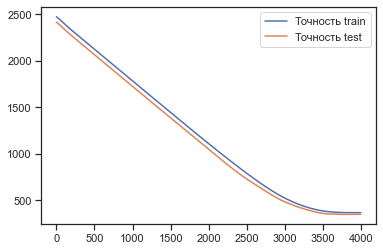

In [56]:
# модель полносвязной нейронной сети для целевого параметра y2 тренируем на исходных данных
modelNN_y2 = Sequential()
modelNN_y2.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y2.add(Dense(32, activation = 'sigmoid'))
modelNN_y2.add(Dense(1, activation = 'linear'))
modelNN_y2.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y2.summary()
history = modelNN_y2.fit(X_train,y_train.iloc[:,1], 
                    epochs=4000, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

In [57]:
y_pred_2 = modelNN_y2.predict(X_test)
MAENN_2 = mean_absolute_error(y_test.iloc[:,1],y_pred_2)
print (MAENN_2)

6/6 [==============================] - 0s 799us/step
370.63444271381877


In [58]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['NeuralNetwork',MAENN_1])
modelsMAE_y2.append(['NeuralNetwork',MAENN_2])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                192       
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
21/21 - 1s - loss: 0.0503 - mae: 0.1818 - val_loss: 0.0479 - val_mae: 0.1757 - 668ms/epoch - 32ms/step
Epoch 2/120
21/21 - 0s - loss: 0.0367 - mae: 0.1539 - val_loss: 0.0444 - val_mae: 0.1720 - 89ms/epoch - 4ms/step
Epoch 3/120
21/21 - 0s - loss: 0.0368 - mae: 0.1545 - val_loss: 0.0447 - val_mae: 0.1717 - 8

Epoch 66/120
21/21 - 0s - loss: 0.0364 - mae: 0.1524 - val_loss: 0.0472 - val_mae: 0.1735 - 37ms/epoch - 2ms/step
Epoch 67/120
21/21 - 0s - loss: 0.0366 - mae: 0.1529 - val_loss: 0.0495 - val_mae: 0.1766 - 36ms/epoch - 2ms/step
Epoch 68/120
21/21 - 0s - loss: 0.0374 - mae: 0.1552 - val_loss: 0.0497 - val_mae: 0.1769 - 37ms/epoch - 2ms/step
Epoch 69/120
21/21 - 0s - loss: 0.0374 - mae: 0.1559 - val_loss: 0.0468 - val_mae: 0.1729 - 37ms/epoch - 2ms/step
Epoch 70/120
21/21 - 0s - loss: 0.0365 - mae: 0.1537 - val_loss: 0.0453 - val_mae: 0.1715 - 38ms/epoch - 2ms/step
Epoch 71/120
21/21 - 0s - loss: 0.0364 - mae: 0.1528 - val_loss: 0.0445 - val_mae: 0.1712 - 38ms/epoch - 2ms/step
Epoch 72/120
21/21 - 0s - loss: 0.0364 - mae: 0.1529 - val_loss: 0.0449 - val_mae: 0.1712 - 38ms/epoch - 2ms/step
Epoch 73/120
21/21 - 0s - loss: 0.0362 - mae: 0.1523 - val_loss: 0.0450 - val_mae: 0.1713 - 38ms/epoch - 2ms/step
Epoch 74/120
21/21 - 0s - loss: 0.0362 - mae: 0.1520 - val_loss: 0.0467 - val_mae: 0.172

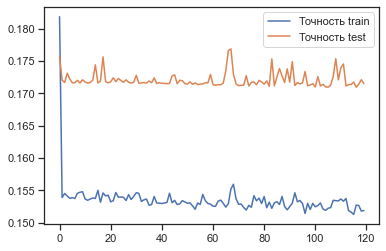

In [59]:
# модель полносвязной нейронной сети для целевого параметра y1 тренируем на нормализованных данных
modelNN_y1 = Sequential()
modelNN_y1.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y1.add(Dense(32, activation = 'sigmoid'))
modelNN_y1.add(Dense(1, activation = 'linear'))
modelNN_y1.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y1.summary()
history = modelNN_y1.fit(X_train_norm,y_train_norm.iloc[:,0], 
                    epochs=120, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                192       
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
21/21 - 1s - loss: 0.1050 - mae: 0.2636 - val_loss: 0.0317 - val_mae: 0.1449 - 511ms/epoch - 24ms/step
Epoch 2/200
21/21 - 0s - loss: 0.0413 - mae: 0.1610 - val_loss: 0.0310 - val_mae: 0.1418 - 37ms/epoch - 2ms/step
Epoch 3/200
21/21 - 0s - loss: 0.0364 - mae: 0.1516 - val_loss: 0.0321 - val_mae: 0.1444 - 3

Epoch 66/200
21/21 - 0s - loss: 0.0356 - mae: 0.1501 - val_loss: 0.0312 - val_mae: 0.1419 - 37ms/epoch - 2ms/step
Epoch 67/200
21/21 - 0s - loss: 0.0355 - mae: 0.1500 - val_loss: 0.0310 - val_mae: 0.1414 - 38ms/epoch - 2ms/step
Epoch 68/200
21/21 - 0s - loss: 0.0356 - mae: 0.1501 - val_loss: 0.0308 - val_mae: 0.1410 - 37ms/epoch - 2ms/step
Epoch 69/200
21/21 - 0s - loss: 0.0358 - mae: 0.1506 - val_loss: 0.0307 - val_mae: 0.1411 - 39ms/epoch - 2ms/step
Epoch 70/200
21/21 - 0s - loss: 0.0361 - mae: 0.1504 - val_loss: 0.0307 - val_mae: 0.1408 - 39ms/epoch - 2ms/step
Epoch 71/200
21/21 - 0s - loss: 0.0355 - mae: 0.1499 - val_loss: 0.0317 - val_mae: 0.1429 - 37ms/epoch - 2ms/step
Epoch 72/200
21/21 - 0s - loss: 0.0355 - mae: 0.1498 - val_loss: 0.0309 - val_mae: 0.1412 - 38ms/epoch - 2ms/step
Epoch 73/200
21/21 - 0s - loss: 0.0358 - mae: 0.1502 - val_loss: 0.0306 - val_mae: 0.1408 - 38ms/epoch - 2ms/step
Epoch 74/200
21/21 - 0s - loss: 0.0355 - mae: 0.1499 - val_loss: 0.0309 - val_mae: 0.141

Epoch 138/200
21/21 - 0s - loss: 0.0365 - mae: 0.1531 - val_loss: 0.0309 - val_mae: 0.1408 - 37ms/epoch - 2ms/step
Epoch 139/200
21/21 - 0s - loss: 0.0357 - mae: 0.1504 - val_loss: 0.0312 - val_mae: 0.1417 - 38ms/epoch - 2ms/step
Epoch 140/200
21/21 - 0s - loss: 0.0354 - mae: 0.1487 - val_loss: 0.0309 - val_mae: 0.1410 - 38ms/epoch - 2ms/step
Epoch 141/200
21/21 - 0s - loss: 0.0356 - mae: 0.1501 - val_loss: 0.0318 - val_mae: 0.1427 - 37ms/epoch - 2ms/step
Epoch 142/200
21/21 - 0s - loss: 0.0354 - mae: 0.1498 - val_loss: 0.0317 - val_mae: 0.1425 - 37ms/epoch - 2ms/step
Epoch 143/200
21/21 - 0s - loss: 0.0353 - mae: 0.1495 - val_loss: 0.0319 - val_mae: 0.1429 - 37ms/epoch - 2ms/step
Epoch 144/200
21/21 - 0s - loss: 0.0353 - mae: 0.1501 - val_loss: 0.0309 - val_mae: 0.1408 - 37ms/epoch - 2ms/step
Epoch 145/200
21/21 - 0s - loss: 0.0353 - mae: 0.1497 - val_loss: 0.0308 - val_mae: 0.1405 - 36ms/epoch - 2ms/step
Epoch 146/200
21/21 - 0s - loss: 0.0357 - mae: 0.1502 - val_loss: 0.0309 - val_m

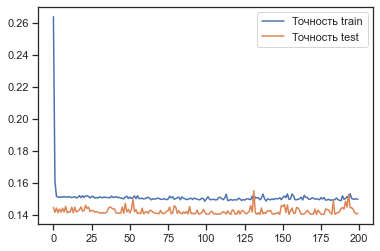

In [60]:
# модель полносвязной нейронной сети для целевого параметра y2 тренируем на нормализованных данных
modelNN_y2 = Sequential()
modelNN_y2.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y2.add(Dense(32, activation = 'sigmoid'))
modelNN_y2.add(Dense(1, activation = 'linear'))
modelNN_y2.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y2.summary()
history = modelNN_y2.fit(X_train_norm,y_train_norm.iloc[:,1], 
                    epochs=200, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

In [61]:
y_pred_1 = modelNN_y1.predict(X_test_norm)
y_pred_2 = modelNN_y2.predict(X_test_norm)

y_pred = np.hstack((y_pred_1,y_pred_2))
y_pred = scaler_norm_y.inverse_transform (y_pred)


MAENN_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
print (MAENN_1)
MAENN_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAENN_2)

6/6 [==============================] - 0s 1ms/step
2.536759109743256
372.34097053675913


In [62]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['NeuralNetwork_norm',MAENN_1])
modelsMAE_y2.append(['NeuralNetwork_norm',MAENN_2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                192       
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
21/21 - 1s - loss: 1.0862 - mae: 0.8330 - val_loss: 1.2022 - val_mae: 0.8856 - 531ms/epoch - 25ms/step
Epoch 2/120
21/21 - 0s - loss: 0.9858 - mae: 0.7946 - val_loss: 1.1779 - val_mae: 0.8851 - 39ms/epoch - 2ms/step
Epoch 3/120
21/21 - 0s - loss: 0.9863 - mae: 0.7960 - val_loss: 1.1922 - val_mae: 0.8842 - 3

Epoch 66/120
21/21 - 0s - loss: 0.9556 - mae: 0.7825 - val_loss: 1.2131 - val_mae: 0.8860 - 38ms/epoch - 2ms/step
Epoch 67/120
21/21 - 0s - loss: 0.9551 - mae: 0.7830 - val_loss: 1.2056 - val_mae: 0.8840 - 37ms/epoch - 2ms/step
Epoch 68/120
21/21 - 0s - loss: 0.9542 - mae: 0.7818 - val_loss: 1.2075 - val_mae: 0.8845 - 38ms/epoch - 2ms/step
Epoch 69/120
21/21 - 0s - loss: 0.9576 - mae: 0.7843 - val_loss: 1.2105 - val_mae: 0.8852 - 38ms/epoch - 2ms/step
Epoch 70/120
21/21 - 0s - loss: 0.9566 - mae: 0.7828 - val_loss: 1.1977 - val_mae: 0.8824 - 37ms/epoch - 2ms/step
Epoch 71/120
21/21 - 0s - loss: 0.9529 - mae: 0.7810 - val_loss: 1.2086 - val_mae: 0.8850 - 37ms/epoch - 2ms/step
Epoch 72/120
21/21 - 0s - loss: 0.9545 - mae: 0.7824 - val_loss: 1.2104 - val_mae: 0.8854 - 38ms/epoch - 2ms/step
Epoch 73/120
21/21 - 0s - loss: 0.9563 - mae: 0.7842 - val_loss: 1.2056 - val_mae: 0.8842 - 38ms/epoch - 2ms/step
Epoch 74/120
21/21 - 0s - loss: 0.9565 - mae: 0.7818 - val_loss: 1.1974 - val_mae: 0.882

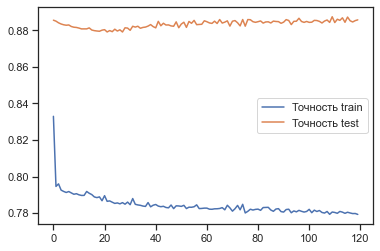

In [63]:
# модель полносвязной нейронной сети для целевого параметра y1 тренируем на стандартизованных  данных
modelNN_y1 = Sequential()
modelNN_y1.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y1.add(Dense(32, activation = 'sigmoid'))
modelNN_y1.add(Dense(1, activation = 'linear'))
modelNN_y1.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y1.summary()
history = modelNN_y1.fit(X_train_std,y_train_std.iloc[:,0], 
                    epochs=120, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                192       
                                                                 
 dense_16 (Dense)            (None, 32)                544       
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
21/21 - 1s - loss: 1.0240 - mae: 0.8028 - val_loss: 0.9089 - val_mae: 0.7673 - 503ms/epoch - 24ms/step
Epoch 2/200
21/21 - 0s - loss: 1.0196 - mae: 0.8020 - val_loss: 0.8996 - val_mae: 0.7628 - 39ms/epoch - 2ms/step
Epoch 3/200
21/21 - 0s - loss: 1.0138 - mae: 0.8000 - val_loss: 0.9010 - val_mae: 0.7633 - 3

Epoch 66/200
21/21 - 0s - loss: 0.9884 - mae: 0.7905 - val_loss: 0.8799 - val_mae: 0.7535 - 37ms/epoch - 2ms/step
Epoch 67/200
21/21 - 0s - loss: 0.9908 - mae: 0.7916 - val_loss: 0.8761 - val_mae: 0.7521 - 37ms/epoch - 2ms/step
Epoch 68/200
21/21 - 0s - loss: 0.9890 - mae: 0.7909 - val_loss: 0.8851 - val_mae: 0.7553 - 38ms/epoch - 2ms/step
Epoch 69/200
21/21 - 0s - loss: 0.9892 - mae: 0.7915 - val_loss: 0.8862 - val_mae: 0.7559 - 38ms/epoch - 2ms/step
Epoch 70/200
21/21 - 0s - loss: 0.9887 - mae: 0.7914 - val_loss: 0.8813 - val_mae: 0.7539 - 38ms/epoch - 2ms/step
Epoch 71/200
21/21 - 0s - loss: 0.9887 - mae: 0.7911 - val_loss: 0.8809 - val_mae: 0.7538 - 37ms/epoch - 2ms/step
Epoch 72/200
21/21 - 0s - loss: 0.9932 - mae: 0.7926 - val_loss: 0.8824 - val_mae: 0.7541 - 37ms/epoch - 2ms/step
Epoch 73/200
21/21 - 0s - loss: 0.9905 - mae: 0.7925 - val_loss: 0.8849 - val_mae: 0.7553 - 38ms/epoch - 2ms/step
Epoch 74/200
21/21 - 0s - loss: 0.9954 - mae: 0.7934 - val_loss: 0.8807 - val_mae: 0.754

Epoch 138/200
21/21 - 0s - loss: 0.9765 - mae: 0.7858 - val_loss: 0.8799 - val_mae: 0.7522 - 39ms/epoch - 2ms/step
Epoch 139/200
21/21 - 0s - loss: 0.9768 - mae: 0.7863 - val_loss: 0.8850 - val_mae: 0.7542 - 37ms/epoch - 2ms/step
Epoch 140/200
21/21 - 0s - loss: 0.9786 - mae: 0.7861 - val_loss: 0.8805 - val_mae: 0.7521 - 37ms/epoch - 2ms/step
Epoch 141/200
21/21 - 0s - loss: 0.9770 - mae: 0.7853 - val_loss: 0.8875 - val_mae: 0.7554 - 38ms/epoch - 2ms/step
Epoch 142/200
21/21 - 0s - loss: 0.9760 - mae: 0.7852 - val_loss: 0.8782 - val_mae: 0.7516 - 37ms/epoch - 2ms/step
Epoch 143/200
21/21 - 0s - loss: 0.9734 - mae: 0.7843 - val_loss: 0.8843 - val_mae: 0.7537 - 36ms/epoch - 2ms/step
Epoch 144/200
21/21 - 0s - loss: 0.9771 - mae: 0.7850 - val_loss: 0.8899 - val_mae: 0.7562 - 37ms/epoch - 2ms/step
Epoch 145/200
21/21 - 0s - loss: 0.9792 - mae: 0.7870 - val_loss: 0.8785 - val_mae: 0.7509 - 36ms/epoch - 2ms/step
Epoch 146/200
21/21 - 0s - loss: 0.9752 - mae: 0.7852 - val_loss: 0.8824 - val_m

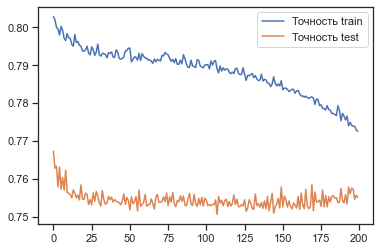

In [64]:
# модель полносвязной нейронной сети для целевого параметра y2 тренируем на стандартизованных данных
modelNN_y2 = Sequential()
modelNN_y2.add(Dense(16,  input_dim=11, activation = 'sigmoid'))
modelNN_y2.add(Dense(32, activation = 'sigmoid'))
modelNN_y2.add(Dense(1, activation = 'linear'))
modelNN_y2.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelNN_y2.summary()
history = modelNN_y2.fit(X_train_std,y_train_std.iloc[:,1], 
                    epochs=200, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

In [65]:
y_pred_1 = modelNN_y1.predict(X_test_std)
y_pred_2 = modelNN_y2.predict(X_test_std)

y_pred = np.hstack((y_pred_1,y_pred_2))
y_pred = scaler_std_y.inverse_transform (y_pred)


MAENN_1 = mean_absolute_error(y_test.iloc[:,0],y_pred[:,0])
print (MAENN_1)
MAENN_2 = mean_absolute_error(y_test.iloc[:,1],y_pred[:,1])
print (MAENN_2)

6/6 [==============================] - 0s 799us/step
2.551285087367128
374.10623486710944


In [66]:
# записываем данные об ошибках в итоговую таблицу
modelsMAE_y1.append(['NeuralNetwork_std',MAENN_1])
modelsMAE_y2.append(['NeuralNetwork_std',MAENN_2])

In [67]:
# Результаты расчета ошибок моделей при предсказании целевого признака "Модуль упругости при растяжении, ГПа"
modelsMAE_y1

[['LinearRegression', 2.540146624552066],
 ['Ridge', 2.537882445323928],
 ['Ridge_norm', 2.5282308269375346],
 ['Ridge_std', 2.5243440708702085],
 ['Lasso', 2.5366102088742966],
 ['ElasticNet', 2.5371148330146633],
 ['BayesianRidge', 2.5256467365389312],
 ['GradientBoostingRegressor', 2.540920559419069],
 ['GradientBoostingRegressor_norm', 2.5463129464347873],
 ['GradientBoostingRegressor_std', 2.5457577907816944],
 ['KNeighborsRegressor', 2.609709581254126],
 ['KNeighborsRegressor_norm', 2.5475175535665717],
 ['KNeighborsRegressor_std', 2.5434973895923045],
 ['DecisionTreeRegressor', 2.714313595456014],
 ['DecisionTreeRegressor_norm', 2.71431359545601],
 ['DecisionTreeRegressor_std', 2.714313595456011],
 ['RandomForestRegressor', 2.498641311209863],
 ['RandomForestRegressor_norm', 2.5295678037605027],
 ['RandomForestRegressor_std', 2.5278521538194814],
 ['AdaBoostRegressor', 2.561115880963196],
 ['AdaBoostRegressor_norm', 2.537263250103053],
 ['AdaBoostRegressor_std', 2.60705810878995

In [68]:
# Результаты расчета ошибок моделей при предсказании целевого признака "Прочность при растяжении, МПа"
modelsMAE_y2

[['LinearRegression', 373.7949432252731],
 ['Ridge', 372.5756003651178],
 ['Ridge_norm', 370.91379516311537],
 ['Ridge_std', 370.3589675933003],
 ['Lasso', 373.7803735026631],
 ['ElasticNet', 373.7644266803178],
 ['BayesianRidge', 370.75537355915486],
 ['GradientBoostingRegressor', 377.2802156316299],
 ['GradientBoostingRegressor_norm', 377.26742329868335],
 ['GradientBoostingRegressor_std', 378.77860924776246],
 ['KNeighborsRegressor', 392.1509689004053],
 ['KNeighborsRegressor_norm', 385.7733933281766],
 ['KNeighborsRegressor_std', 400.8241620766011],
 ['DecisionTreeRegressor', 401.35825569836464],
 ['DecisionTreeRegressor_norm', 394.68514033989635],
 ['DecisionTreeRegressor_std', 401.35825569836476],
 ['RandomForestRegressor', 375.99597021415144],
 ['RandomForestRegressor_norm', 374.8413455204395],
 ['RandomForestRegressor_std', 376.7599376943874],
 ['AdaBoostRegressor', 376.87481049283906],
 ['AdaBoostRegressor_norm', 385.15444070270576],
 ['AdaBoostRegressor_std', 386.850038628483

In [69]:
# Сформируем датафрэйм с результатами
a = np.array(modelsMAE_y1)
b = np.array(modelsMAE_y2)
model_errors = pd.DataFrame({'Model_name': a[:,0], 'Модуль упругости при растяжении, ГПа': a[:,1], 
                             'Прочность при растяжении, МПа': b[:,1]})
model_errors = model_errors.astype({'Модуль упругости при растяжении, ГПа': np.float16, 'Прочность при растяжении, МПа': np.float16})
model_errors


,Model_name,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
0,LinearRegression,2.541016,373.75
1,Ridge,2.537109,372.50
2,Ridge_norm,2.527344,371.00
3,Ridge_std,2.523438,370.25
4,Lasso,2.537109,373.75
5,ElasticNet,2.537109,373.75
6,BayesianRidge,2.525391,370.75
7,GradientBoostingRegressor,2.541016,377.25
8,GradientBoostingRegressor_norm,2.546875,377.25
9,GradientBoostingRegressor_std,2.544922,378.75


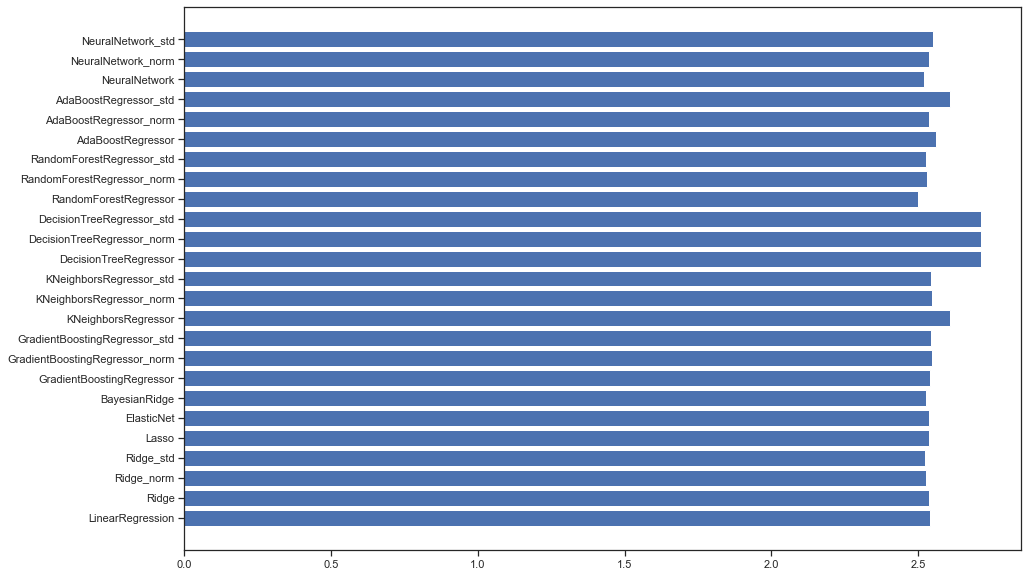

In [70]:
# Построим гистограмму 
plt.figure(figsize=(15, 10))
plt.barh(model_errors['Model_name'], model_errors['Модуль упругости при растяжении, ГПа'])
plt.show()

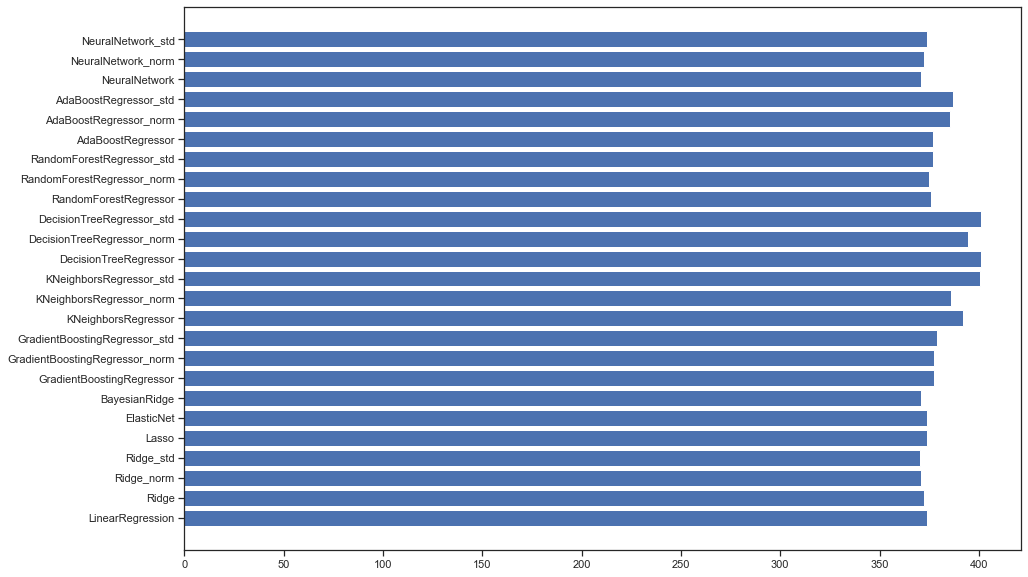

In [71]:
# Построим гистограмму 
plt.figure(figsize=(15, 10))
plt.barh(model_errors['Model_name'], model_errors['Прочность при растяжении, МПа'])
plt.show()

In [72]:
# Запишем результаты сравнения в файл
model_errors.to_excel('./Data/Model_compare_Clear.xlsx')

# Выводы к разделу 3.1
1. Проведена оценка влияния аномалий на качество моделей. 
2. Все модели показали ухудшение точности при удалении выбросов
